In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import os
import re
import yaml
import sys
import subprocess
import math
import glob
import time
import random
from statistics import mean

# Parallel focusing 
This is python code written in jupyter notebook which implements different methods for point-point to parallel-parallel focusing. It uses software ASTRA, a program to simulate beam dynamics in accelerators. Programs in this notebook run in the same directory as are the ASTRA executables, mainly generator and Astra. 

The initial information are regarding the input file to Astra and information about reference particles. I used 5 different reference particles to determine the focusing properties of a setup- the first particle with 0 offset and 0 angle, moving along the z axis. This particle should not move in the transverse direction. Next 2 particles would be with initial offsets in the x and y directions respectively, but because this is point-point focusing, I am not using these. Last 2 have angles in the x and y direction respectively.

The magnets that are used are permanent quadrupole magnets with set gradients, lengths and bore diameters. These parameters can be changed, but for now they are set to values of 3 quadrupole magnets in LLR laboratory. The variables which will be changing are distances between them and the initial momentum. D1 is the distance from the source to the 1. quadrupole magnet. Realistically, D1 is only up to fringe fields which are magnetic fields outside the magnet's bores (reach 3*bore size in ASTRA). This option can be changed using TopHatShapedQuads() function. D2 and D3 are distances between first 2 and last 2 magnets in sequence. Last variable that can be changed is the initial longitudinal momentum of particles.

For running beam simulations, one can define it's initial parameters like spread of transverse momenta, spread of longitudinal energy, spread of offsets in the x and y directions as well as in the longitudinal direction. Also number of initial particles, space charge, secondary particle emission or other parameters can be changed in file parallelBeam.in.


In [2]:
fileName = "parallelBeam"
fillNumber = "001"
setupLength = 1.5 #m
setupLengthStr = "0150"
longitudalEnergy = "5.0E+8" #eV

#offsets and angles for reference particles
xoffset = "2.0E-4" #m
yoffset =  "2.0E-4" #m
xmom = "1.0E+6" #eV
ymom = "1.0E+6" #eV


#parameters of magnets 
#all methods are equivalent in integrated gradient along z

#lengths of magnets with top hat shaped fields
lengthQ1 = 0.03619  #m
lengthQ2 = 0.12429  #m
lengthQ3 = 0.09596  #m


#lengths of magnets for field profiles. Here it is at FWHM. These are the same as for the field maps in cavity namelist
FPlengthQ1 = 0.035
FPlengthQ2 = 0.120
FPlengthQ3 = 0.105


#----------------------------------------------
#diameters of bores
boreQ1 = 0.007
boreQ2 = 0.018
boreQ3 = 0.030

#input parameters of the beam
nParticles = "500"
sig_z=0.1    #mm
sig_Ekin=3E+3     #keV
sig_x=2.0E-3    #mm
sig_y=2.0E-3    #mm
#sig_px =3E+6    #eV
#sig_py =3E+6    #eV

sig_xAngle = 1  #mrad
sig_yAngle = 1  #mrad


In [3]:
dataD1 = []
dataD2 = []
dataD3 = []
dataMom = []
dataSum = []


## Function to change input settings
Function changeInputData() is a function created to change input variables for ASTRA. The first argument is the name of the parameter that needs to be changed, the second is the value. After that is topHatShapedQuads() which changes settings between ideal or realistic quadrupoles. To change the momentum in the z direction, one can use changeMomZ(). Files test0.ini all the way to test4.ini are input data for 5 different runs. File test0.ini has 0. reference particle with 0 offset and 0 initial angle, 1 and 2 have offsets in the x and y directions respectively and the last 2 have predefined angles. All of them should be parallel in the end. Lastly, function update() should be run to double check that all parameters are set to the right values.

In [4]:
def changeInputData(tag, newVar):
#universal function which changes input parameter in input file to Astra
    try:
        # Open the file for reading
        with open(fileName + ".in", 'r') as file:
            lines = file.readlines()

        # Prepare the replacement string
        replacement = " " + tag + "=" + str(newVar) + "\n"

        # Iterate over the lines to find and replace the target line
        for i, line in enumerate(lines):
            if tag in line:
                lines[i] = replacement
                break  # Assuming there's only one occurrence to replace

        # Write the modified lines back to the file
        with open(fileName + ".in", 'w') as file:
            file.writelines(lines)

        #print(f"Replaced '{tag}' with '{replacement.strip()}'.")

    except FileNotFoundError:
        print("The file " + fileName + ".ini was not found.")
    except Exception as e:
        print(f"An error occurred when trying to change '{tag}' to variable '{newVar}': {e}")


    
    return

In [5]:
def enable(tag):
    try:
        # Open the file for reading
        with open(fileName + ".in", 'r') as file:
            lines = file.readlines()

        # Prepare the replacement string

        # Iterate over the lines to find and replace the target line
        for i, line in enumerate(lines):
            if tag in line:
                lines[i] = lines[i].replace("!","")
                break  # Assuming there's only one occurrence to replace

        # Write the modified lines back to the file
        with open(fileName + ".in", 'w') as file:
            file.writelines(lines)

        #print(f"Replaced '{tag}' with '{replacement.strip()}'.")

    except FileNotFoundError:
        print("The file " + fileName + ".in was not found.")
    except Exception as e:
        print(f"An error occurred when trying to change '{tag}' to variable '{newVar}': {e}")

    return

In [6]:
def readOption(tag):
    try:
        # Open the file for reading
        with open(fileName + ".in", 'r') as file:
            lines = file.readlines()

        # Prepare the replacement string

        # Iterate over the lines to find and replace the target line
        setting = ''
        for i, line in enumerate(lines):
            if tag in line:
                setting = line.split("=")
                break  # Assuming there's only one occurrence to replace
        return setting[-1]

    except FileNotFoundError:
        print("The file " + fileName + ".in was not found.")
        return -1
    except Exception as e:
        print(f"An error occurred when trying to change '{tag}' to variable '{newVar}': {e}")
        return -1
    

In [7]:
def disable(tag):
    try:
        # Open the file for reading
        with open(fileName + ".in", 'r') as file:
            lines = file.readlines()

        # Prepare the replacement string

        # Iterate over the lines to find and replace the target line
        for i, line in enumerate(lines):
            if tag in line:
                if "!" in line:
                    break
                else:
                    lines[i] = "!" + lines[i]
                break  # Assuming there's only one occurrence to replace

        # Write the modified lines back to the file
        with open(fileName + ".in", 'w') as file:
            file.writelines(lines)

        #print(f"Replaced '{tag}' with '{replacement.strip()}'.")

    except FileNotFoundError:
        print("The file " + fileName + ".in was not found.")
    except Exception as e:
        print(f"An error occurred when trying to change '{tag}' to variable '{newVar}': {e}")

    return

In [40]:
def checkOption(tag):
    #check if this option is enabled = True or disabled = False
    with open(fileName + ".in", 'r') as file:
        lines = file.readlines()

    for i, line in enumerate(lines):
        if tag in line:
            if "!" in line:
                return False
            else:
                return True
    

In [8]:
def topHatShapedQuads(switcher):
    #switcher between idealised quadrupoles without fringe fields or not
    
    if switcher == 0:  #top hat shaped quads from namelist quadrupole
        changeInputData("Lquad", "T")
        changeInputData("LEField", "F") 
        changeInputData("Q_bore(1)", "1E-9")
        changeInputData("Q_bore(2)", "1E-9")
        changeInputData("Q_bore(3)", "1E-9")
        changeInputData("Q_length(1)",str(lengthQ1))
        changeInputData("Q_length(2)",str(lengthQ2))
        changeInputData("Q_length(3)",str(lengthQ3))        
        disable("Q_type(1)")
        disable("Q_type(2)")
        disable("Q_type(3)")
        enable("Q_grad(1)")
        enable("Q_grad(2)")
        enable("Q_grad(3)")
    elif switcher == 1:  #quadrupole fields with ideal gradients
        changeInputData("Lquad", "T")
        changeInputData("LEField", "F") 
        changeInputData("Q_bore(1)", str(boreQ1))
        changeInputData("Q_bore(2)", str(boreQ2))
        changeInputData("Q_bore(3)", str(boreQ3))
        changeInputData("Q_length(1)",str(lengthQ1))
        changeInputData("Q_length(2)",str(lengthQ2))
        changeInputData("Q_length(3)",str(lengthQ3))    
        disable("Q_type(1)")
        disable("Q_type(2)")
        disable("Q_type(3)")
        enable("Q_grad(1)")
        enable("Q_grad(2)")
        enable("Q_grad(3)")
    elif switcher == 2:  #quadrupole fields with custom gradients
        changeInputData("Lquad", "T")
        changeInputData("LEField", "F") 
        changeInputData("Q_bore(1)", str(boreQ1))
        changeInputData("Q_bore(2)", str(boreQ2))
        changeInputData("Q_bore(3)", str(boreQ3))
        changeInputData("Q_type(1)", "'3Dcavity1data.dat'")
        changeInputData("Q_type(2)", "'3Dcavity2data.dat'")
        changeInputData("Q_type(3)", "'3Dcavity3data.dat'")
        disable("Q_grad(1)")
        disable("Q_grad(2)")
        disable("Q_grad(3)")
        changeInputData("Q_length(1)",str(FPlengthQ1))
        changeInputData("Q_length(2)",str(FPlengthQ2))
        changeInputData("Q_length(3)",str(FPlengthQ3))   
        disable("Q_length(1)")
        disable("Q_length(2)")
        disable("Q_length(3)")
    elif switcher == 3: #field maps in cavities
        changeInputData("Lquad", "F")
        changeInputData("LEField", "T")
    else:
        print("Wrong input, only 0 through 3: 0 = top hat shaped fields, 1 = Astra generated quadrupole magnets with fringe fields, 2 = field profiles of gradient for measured quadrupoles, 3 = field maps of the measured magnets.")
    
    return       

In [9]:
def aperture(yes):

    if yes:
        changeInputData("LApert", "T")
    else:
        changeInputData("LApert","F")    
        

In [10]:
def changeMom(xAngle, yAngle, pz, xoff, yoff): 
    nameOfFiles = ["test0.ini", "test1.ini", "test2.ini", "test3.ini", "test4.ini"]
    try:
        testData = ""

        #change longitudinal momentum for files test0.ini through test4.ini and test.ini
        for name in nameOfFiles:
            with open(name, "r") as file:
                line = file.readlines()[0].split()

            #offset update
            if name == "test3.ini" and yoff != -1:
                line[1] = str(yoff) 
            if name == "test4.ini" and xoff != -1:
                line[0] = str(xoff)


            
            #momentum update
            if name == "test1.ini" and xAngle != -1:
                line[3] = str(xAngle*pz*1e-3)
            if name == "test2.ini" and yAngle != -1:
                line[4] = str(yAngle*pz*1e-3)

            
            line[5] = str(pz)

            inputData = ""
            for num in line:
                inputData += num + " "
            testData += inputData + "\n"
            with open(name, "w") as file:
                file.write(inputData)

    
        with open("test.ini","w") as file:
            file.write(testData)
    
        #generate new data with new momentum
        changeInputData("Ref_Ekin", str(pz))
        
        #uncomment once beam is being used!!!
        #subprocess.run("./generator " + fileName + " > output.txt" , shell=True,check=True,executable='/bin/bash' )
        #print(f"Successfully changed momentum to files and ran a generation of particles saved to '{fileName}'.")

    except FileNotFoundError:
        print("One of the files when changing initial offsets and momenta was not found.")
    except Exception as e:
        print(f"An error occurred when trying to change longitudinal momentum: {e}")

    return
    

In [66]:
def changePositions(D1,D2,D3, D4=None):

    Q1L, Q2L, Q3L = 0,0,0
    if readOption('LEField') == readOption('Lquad'):
        print(f"Something is wrong, quadrupole namelist and cavity namelist are both {readOption('Lquad')}. Leaving.")
        return 1
    elif readOption('LEField') == 'T' or not checkOption("Q_grad(1)"):
        Q1L = FPlengthQ1
        Q2L = FPlengthQ2
        Q3L = FPlengthQ3
    else:
        Q1L = lengthQ1
        Q2L = lengthQ2
        Q3L = lengthQ3

    if not D4 == None:
        endPoint = D1 + Q1L + D2 + Q2L + D3 + Q3L + D4
        changeInputData("ZSTOP",str(endPoint))
    else:
        changeInputData("ZSTOP",str(1.5))

    #changing the positions of apertures
    ap1 = str(D1) + " " + str(boreQ1*1E+3/2) + "\n" + str(D1 + Q1L) + " " + str(boreQ1*1E+3/2)
    with open("aperture1.dat", "w") as file:
        file.write(ap1)
    ap2 = str(D1 + Q1L + D2) + " " + str(boreQ2*1E+3/2) + "\n" + str(D1 + Q1L + D2 + Q2L) + " " + str(boreQ2*1E+3/2)
    with open("aperture2.dat", "w") as file:
        file.write(ap2)
    ap3 = str(D1 + Q1L + D2 + Q2L + D3) + " " + str(boreQ3*1E+3/2) + "\n" + str(D1 + Q1L + D2 + Q2L + D3 + Q3L) + " " + str(boreQ3*1E+3/2)
    with open("aperture3.dat", "w") as file:
        file.write(ap3)


    if checkOption("Q_grad(1)"):
        changeInputData("Q_pos(1)",str(D1 + lengthQ1/2) )
        changeInputData("Q_pos(2)",str(D1 + lengthQ1 + D2 + lengthQ2/2) )
        changeInputData("Q_pos(3)",str(D1 + lengthQ1 + D2 + lengthQ2 + D3 + lengthQ3/2) )
    else:
        changeInputData("Q_pos(1)",str(D1) )
        changeInputData("Q_pos(2)",str(D1 + FPlengthQ1 + D2 ) )
        changeInputData("Q_pos(3)",str(D1 + FPlengthQ1 + D2 + FPlengthQ2 + D3) )

    
    #changing the positions of cavities
    changeInputData("C_pos(1)",str(D1))
    changeInputData("C_pos(2)", str(D1 + FPlengthQ1 + D2))
    changeInputData("C_pos(3)", str(D1 + FPlengthQ1 + D2 + FPlengthQ2 + D3))    

    return [D1 + Q1L/2, D1 + Q1L + D2 + Q2L/2 ,D1 + Q1L + D2 + Q2L + D3 + Q3L/2, ]


In [12]:
def update():

    changeInputData("ZSTOP", str(setupLength) )

    #change properties of magnets
    changeInputData("Q_length(1)", str(lengthQ1))
    changeInputData("Q_length(2)", str(lengthQ2))
    changeInputData("Q_length(3)", str(lengthQ3))
    
    #change parameters of the beam
    changeInputData("IPart", str(nParticles))
    '''
    changeInputData("sig_z",str(sig_z))
    changeInputData("sig_Ekin", str(sig_Ekin))
    changeInputData("sig_x", str(sig_x))
    changeInputData("sig_y", str(sig_y))
    changeInputData("sig_px", str(sig_px))
    changeInputData("sig_py", str(sig_py))
    '''
    dataD1.clear()
    dataD2.clear()
    dataD3.clear()
    dataSum.clear()
    
    print(f"Succesfully updated all variables.")

    return

## Functions that make life easier
Here below are some one-liners or almost one-liners that run several times and return some specific values used in bigger algorithms implemented for example in refParticles().

In [80]:
def setupSize(D1, D2, D3, D4):

    size = 0
    if D4 == None:
        return D1 + lengthQ1 + D2 + lengthQ2 + D3 + lengthQ3 
    else:
        return D1 + lengthQ1 + D2 + lengthQ2 + D3 + lengthQ3 + D4
        

In [14]:
def activeParticles():
    #function which returns the number of particles that stayed in the beam w.r.t. original number of particles in the beam
    data = loadDataRef(setupLengthStr)

    lost = 0
    for line in data:
        if line[2] == setupLength:
            continue
        zpos = math.fabs(line[2])
        if zpos > 0.05: #if particle more than 5 cm from the reference particle, it is considered lost
            lost += 1

    return (str(len(data) - lost)+"/" + str(len(data)))

In [15]:
def isRef0Straight(px, py):
    #function which checks if 0. ref particle did not move
    if px == 0 and py == 0:
        return True
    else:
        return False

In [16]:
def differLine(line):
    #splits a line and converts string to float
    lineSplitted = line.split()
    
    return [float(num) for num in lineSplitted]    

In [17]:
def loadDataRef(arg):
#open and load data about reference particle
#z [m], t [ns], pz [MeV/c], dE/dz [MeV/c], Larmor Angle [rad], x off [mm], y off [mm], px [eV/c], py [eV/c]
    data = []
    #assuming setup length
    with open(fileName + "." + arg + "." + fillNumber,"r") as file:
        for line in file:
            newLine = differLine(line)
            data.append(newLine)

    return data
    

In [18]:
def fill4DGraph(D1, D2,D3,mom,sum):
    #function that fills info about each run, these data can be later used for some plots
    dataD1.append(D1)
    dataD2.append(D2)
    dataD3.append(D3)
    dataMom.append(mom)
    dataSum.append(sum)
    
    return

In [73]:
def parallelFocusing(data):
    #parallel-parallel focusing: x'**2 + y'**2  
    sum =  math.sqrt((data[1][3]*1e+3/data[1][5])**2 + (data[2][4]*1e+3/data[2][5])**2 )
    return sum

In [74]:
def pointFocusing(data):
    #to point-point focusing: x**2 + y**2
    sum = math.sqrt( pow(data[1][0]*1e+3,2) + pow(data[2][1]*1e+3,2) )
    return sum

In [75]:
def xLineFocusing(data):
    #to point-parallel focusing: x'**2 + y**2
    sum = math.sqrt( pow( data[1][3]*1e+3/data[1][5], 2) +  pow(data[2][1]*1e+3,2) )
    return sum    

In [76]:
def yLineFocusing(data):
    #to parallel-point focusing: x**2 + y'**2
    sum = math.sqrt( pow( data[2][4]*1e+3/data[2][5], 2) +  pow(data[1][0]*1e+3,2) )
    return sum

In [22]:
def calculatePercentage(acceptance, xAng_sig , yAng_sig ):
    #this function calculates the percentage of particles that pass the setup for a certain x and y gaussian initial spread   
    
    xLost = 2*sc.stats.norm(loc = 0 , scale = xAng_sig).cdf(-acceptance[0])
    yLost = 2*sc.stats.norm(loc = 0 , scale = yAng_sig).cdf(-acceptance[1])
    
    xPassed = 1-xLost
    yPassed = 1-yLost

    
    passed = xPassed * yPassed

    return passed    

In [23]:
def recalculateAcceptance(Max, zMax, off ):
    angle = (Max - off)/zMax
    return angle

In [77]:
def checkAngleAcceptance(D1,D2,D3,D4, momZ, xAng = sig_xAngle, yAng = sig_yAngle):
    #goes from the larger values, if a reference particle gets lost, it's last z position is not setup length
    
    Qpos = changePositions(D1, D2, D3, D4)
    
    changeMom(sig_xAngle, sig_yAngle, momZ, -1, -1)
    data = runRef(D1, D2, D3,D4, momZ, True)
    
    #calculate x initial angle acceptance
    Q1_start = Qpos[0] - lengthQ1/2
    Q1_end = Qpos[0] + lengthQ1/2

    Q2_start = Qpos[1] - lengthQ2/2
    Q2_end = Qpos[1] + lengthQ2/2

    Q3_start = Qpos[2] - lengthQ3/2
    Q3_end = Qpos[2] + lengthQ3/2

    #variables where max values will be saved
    maxOffsetX = [0,0,0]
    maxOffsetY = [0,0,0]
    maxOffsetXzpos = [0,0,0]
    maxOffsetYzpos = [0,0,0]
    
    #check x
    for line in data[1]:
        #check Q1
        if line[0] > Q1_start and line[0]< Q1_end:
            if math.fabs(line[5]) > maxOffsetX[0]:
                maxOffsetX[0] = math.fabs(line[5])
                maxOffsetXzpos[0] = line[0]
                
        #check Q2
        if line[0] > Q2_start and line[0]< Q2_end:
            if math.fabs(line[5]) > maxOffsetX[1]:
                maxOffsetX[1] = math.fabs(line[5])
                maxOffsetXzpos[1] = line[0]

        #check Q3
        if line[0] > Q3_start and line[0]< Q3_end:
            if math.fabs(line[5]) > maxOffsetX[2]:
                maxOffsetX[2] = math.fabs(line[5])
                maxOffsetXzpos[2] = line[0]

    #check y
    for line in data[2]:
        #check Q1
        if line[0] > Q1_start and line[0]< Q1_end:                
            if math.fabs(line[6]) > maxOffsetY[0]:
                maxOffsetY[0] = math.fabs(line[6])
                maxOffsetYzpos[0] = line[0]
                
        #check Q2
        if line[0] > Q2_start and line[0]< Q2_end:
            if math.fabs(line[6]) > maxOffsetY[1]:
                maxOffsetY[1] = math.fabs(line[6])
                maxOffsetYzpos[1] = line[0]

        #check Q3
        if line[0] > Q3_start and line[0]< Q3_end:
            if math.fabs(line[6]) > maxOffsetY[2]:
                maxOffsetY[2] = math.fabs(line[6])
                maxOffsetYzpos[2] = line[0]



    if maxOffsetX[0] > boreQ1*500 or maxOffsetY[0]> boreQ1*500:
        print(f"Somethings wrong with angle acceptance of Q1.")
        return 0

    if maxOffsetX[1] > boreQ2*500 or maxOffsetY[1]> boreQ2*500:
        print(f"Somethings wrong with angle acceptance of Q2.")
        return 0
        
    if maxOffsetX[2] > boreQ3*500 or maxOffsetY[2]> boreQ3*500:
        print(f"Somethings wrong with angle acceptance of Q3.")
        return 0

    #mangular acceptance separately for x and y 
    maxValsX = [ (sig_xAngle*boreQ1*1e+3)/(2*maxOffsetX[0]), (sig_xAngle*boreQ2*1e+3)/(2*maxOffsetX[1]), (sig_xAngle*boreQ3*1e+3)/(2*maxOffsetX[2])  ]
    maxValsY = [ (sig_yAngle*boreQ1*1e+3)/(2*maxOffsetY[0]), (sig_yAngle*boreQ2*1e+3)/(2*maxOffsetY[1]), (sig_yAngle*boreQ3*1e+3)/(2*maxOffsetY[2])  ]

    
    xAngAccept = min(maxValsX)
    yAngAccept = min(maxValsY)
    
    percentagePassed = calculatePercentage([xAngAccept, yAngAccept], xAng, yAng) #possible to add x,y offsets
    
    
    #get the beam size for this sigma x and y angle spread
    changeMom(xAng, yAng, momZ, -1, -1)
    data = runRef(D1, D2, D3, momZ, True)
    xBeamSize = data[1][-1][5]
    yBeamSize = data[2][-1][6]

    
    return [xAngAccept, yAngAccept, xAng, yAng, xBeamSize, yBeamSize, percentagePassed]

# Function RunRef()
Function runRef() is the function that does most of the work. The arguments are the specific D1, D2, D3 and longitudinal momentum that is of interest. It is created for 3 reference particles: 0 angle, x angle, y angle. It changes the variables in the input file for Astra, runs the program for each reference particle separately, loads the output of the program. If argument moreData is set to True, it returns the entire trajectories of the particles, if it is false only information at the end of setup. 

In [67]:
def runRef(D1, D2, D3, D4,momZ, moreData):
    #this function runs Astra with 5 different reference particles for specific D1,D2,D3

    changePositions(D1,D2,D3, D4)
    changeMom(-1, -1, momZ, -1, -1)


    #if moreData, then provide tracking for each of the reference particles and return it for plotting
    if moreData:
        inputDataName = ["test0.ini", "test1.ini", "test2.ini", "test3.ini", "test4.ini"]
        outputMoreData = []
        for i in range(len(inputDataName)):
            changeInputData("Distribution", inputDataName[i] )
            result = subprocess.run("source /opt/intel/oneapi/setvars.sh > out.txt && ./Astra " + fileName + " > output.txt",capture_output=True, text=True, shell=True,check=True,executable='/bin/bash' )

            if result.returncode != 0:
                print(f"Astra returned an error '{subprocess.CalledProcessError.stderr}'. ")
                return 1
            
            currentData = loadDataRef("ref")
            
            #condition for 0. ref particle-> it cannot move
            if i == 0 and not isRef0Straight(currentData[-1][7], currentData[-1][8]):
                print(f"Reference 0 particle with 0 offset and 0 angle moved in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'.")
                return 1
            #condition to check if the particle came all the way to the end
            distFromEnd = math.fabs(currentData[-1][0] - setupLength)
            if distFromEnd > 0.1:
                print(f"Reference particle '{i}' did not get to the end in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'. ")
                return 1
            

            outputMoreData.append(currentData)

        return outputMoreData
        
    else:
        inputDataName = ["test0.ini", "test1.ini", "test2.ini"]
        outputMoreData = []
        for i in range(len(inputDataName)):
            changeInputData("Distribution", inputDataName[i] )
            result = subprocess.run("source /opt/intel/oneapi/setvars.sh > out.txt && ./Astra " + fileName + " > output.txt",capture_output=True, text=True, shell=True,check=True,executable='/bin/bash' )

            if result.returncode != 0:
                print(f"Astra returned an error '{subprocess.CalledProcessError.stderr}'. ")
                return 1
            
            currentData = loadDataRef("ref")
            
            #condition for 0. ref particle-> it cannot move
            if i == 0 and not isRef0Straight(currentData[-1][7], currentData[-1][8]):
                print(f"Reference 0 particle with 0 offset and 0 angle moved in setup with D1 = '{D1}', D2 = '{D2}' and D3 = '{D3}'.")
                return 1
                
            #condition to check if the particle came all the way to the end
            distFromEnd = math.fabs(currentData[-1][0] - setupLength)
            if distFromEnd > 0.1:
                print(f"Reference particle {i} did not get to the end in setup with D1 = {D1}, D2 = {D2} and D3 = {D3}. ")
                return 1
            
            outputMoreData.append( [currentData[-1][5]*1e-3, currentData[-1][6]*1e-3, currentData[-1][0], currentData[-1][7], currentData[-1][8], currentData[-1][2]*1e+6] )

        
        return outputMoreData

## Plotting functions
Several functions to plot output from reference particles.

In [26]:
def separateDataXYZ(data):

    z0 = []
    x0 = []
    y0 = []
    for element in data:
        z0.append(element[0])
        x0.append(element[5])
        y0.append(element[6])
        
    XYZ = []
    XYZ.append(x0)
    XYZ.append(y0)
    XYZ.append(z0)
    
    return XYZ

In [27]:
def plotRefXY(D1, D2, D3, mom):

    #print(f"Running best setup again to get full data.")
    dataBest = runRef(D1, D2, D3, mom, True)

    data0 = separateDataXYZ(dataBest[0])
    data3 = separateDataXYZ(dataBest[1])
    data4 = separateDataXYZ(dataBest[2])


    plt.plot(data0[2], data0[0], label='0 offset, initial 0 angle', color='blue')
    plt.plot(data3[2], data3[0], label='x offset, initial x angle', color='red')
    plt.plot(data3[2], data3[1], label='y offset, initial x angle', color='yellow')
    plt.plot(data4[2], data4[0], label='x offset, initial y angle', color='green')
    plt.plot(data4[2], data4[1], label='y offset, initial y angle', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("offset [mm]")

    plt.show()
    
    return

In [28]:
def plotRefXY1(D1, D2, D3, mom,title):

    #print(f"Running best setup again to get full data.")
    dataBest = runRef(D1, D2, D3, mom, True)

    data0 = separateDataXYZ(dataBest[0])
    data3 = separateDataXYZ(dataBest[1])
    data4 = separateDataXYZ(dataBest[2])


    plt.plot(data0[2], data0[0], label='0 offset, initial 0 angle', color='blue')
    plt.plot(data3[2], data3[0], label='x offset, initial x angle', color='red')
    plt.plot(data3[2], data3[1], label='y offset, initial x angle', color='yellow')
    plt.plot(data4[2], data4[0], label='x offset, initial y angle', color='green')
    plt.plot(data4[2], data4[1], label='y offset, initial y angle', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("offset [mm]")
    plt.title(title)

    plt.show()
    
    plt.clf()
    plt.cla()

    
    return

In [29]:
def plotRefXY2(D1, D2, D3, mom,title, tag):

    #print(f"Running best setup again to get full data.")
    dataBest = runRef(D1, D2, D3, mom, True)

    data0 = separateDataXYZ(dataBest[0])
    data3 = separateDataXYZ(dataBest[1])
    data4 = separateDataXYZ(dataBest[2])


    plt.plot(data0[2], data0[0], label='0 offset, initial 0 angle', color='blue')
    plt.plot(data3[2], data3[0], label='x offset, initial x angle', color='red')
    plt.plot(data3[2], data3[1], label='y offset, initial x angle', color='yellow')
    plt.plot(data4[2], data4[0], label='x offset, initial y angle', color='green')
    plt.plot(data4[2], data4[1], label='y offset, initial y angle', color='purple')

    plt.legend()

    plt.xlabel("z [m]")
    plt.ylabel("offset [mm]")
    plt.title(title)

    plt.savefig("resFigs/" + tag + ".pdf", format="pdf",  dpi=300)
    
    plt.clf()
    plt.cla()

    
    return

This is the code where one can run the equidistant intervals algorithm, I put it into a function so it does not do anything when I am running the entire notebook. One sets manually the ranges for each parameter/variable and the number of intervals. If the lower and upper limits are equal, then the variable is constant. Remember, the number of iterations is nInt to the number of non-constant variables times 3.

In [30]:
def func(D, D1, mom):
    
    dataCurrent = runRef(D1, D[0], D[1], mom, False)
    if dataCurrent == 1:
        return 1E+9
    sum = angleCalculation(dataCurrent)
    return sum

In [31]:
def func3(D, mom):
    
    dataCurrent = runRef(D[0], D[1], D[2], mom, False)
    sumX = angleCalculation(dataCurrent)

    return sumX

## ComparisonAnaNum()
For this comparison, the fringe fields stay off. The first run is with analytical solution, the second run is with found numerical solution. The 2 results can be compared in a table below. The differences in D2,D3 are in Delta D2 and Delta D3. Parameters of runs are also there.

In [45]:
topHatShapedQuads(1)
runRef(0.1, 0.3, 0.3, 450E+6, False)


[[0.0, 0.0, 1.5, 0.0, 0.0, 450000000.0],
 [0.00022113, 0.0, 1.5, -896560.0, 0.0, 450000000.0],
 [0.0, -0.0039657, 1.5, 0.0, -2557500.0, 449990000.0]]

In [46]:
topHatShapedQuads(2)
runRef(0.1, 0.3, 0.3, 450E+6, False)


[[0.0, 0.0, 1.5, 0.0, 0.0, 450000000.0],
 [0.00024095, 0.0, 1.5, -881780.0, 0.0, 450000000.0],
 [0.0, -0.0039411, 1.5, 0.0, -2534200.0, 449990000.0]]

In [36]:
args = sys.argv
args.pop(0)
if len(args) != 1:
    print(f"more than 1 argument")
tolerance = float(args[0])

topHatShapedQuads(0)
update()
#boundaries for D2, D3    
Dmin = [0.0, 0.0]
Dmax = [0.4, 0.4]
bounds = [(low, high) for low, high in zip(Dmin, Dmax)]

D1 = [0.1]
#for i in range(1,21):
#    D1.append(i/100)

D2P1, D2P2, D2NM1, D2NM2, D2C1,D2C2 = [], [], [],[], [], []
D3P1, D3P2, D3NM1, D3NM2, D3C1,D3C2 = [], [], [],[], [], []
funkValP1, funkValP2, funkValNM1, funkValNM2, funkValC1, funkValC2 = [], [], [],[] ,[],[]
timeP1, timeP2, timeNM1, timeNM2, timeC1, timeC2 = [], [], [], [], [], []

for d1 in D1:    
    time1 = time.time()
    res = sc.optimize.minimize(func, (0.1, 0.1),method="Powell", bounds=bounds,tol=tolerance, args=( d1, 4.5E+8 ))
    time2 = time.time()
    D2P1.append(res.x[0])
    D3P1.append(res.x[1])
    funkValP1.append(angleCalculation(runRef(d1, *res.x, 4.5E+8, False)))
    timeP1.append(time2 -time1)
    
    time1 = time.time()
    bounds2 = [(res.x[0]-0.05, res.x[0]+0.05),(res.x[1]-0.05, res.x[1]+0.05)]
    res = sc.optimize.minimize(func, (random.uniform(res.x[0]-0.05, res.x[0]+0.05), random.uniform(res.x[1]-0.05, res.x[1]+0.05)),method="Powell", bounds=bounds2,tol=tolerance, args=( d1, 4.5E+8 ))
    time2 = time.time()
    D2P2.append(res.x[0])
    D3P2.append(res.x[1])
    funkValP2.append(angleCalculation(runRef(d1, *res.x, 4.5E+8, False)))
    timeP2.append(time2 -time1)
    #------------------------------------------------------------------
    time1 = time.time()
    res = sc.optimize.minimize(func, (0.1, 0.1),method="Nelder-Mead", bounds=bounds,tol=tolerance, args=( d1, 4.5E+8 ))
    time2 = time.time()
    D2NM1.append(res.x[0])
    D3NM1.append(res.x[1])
    funkValNM1.append(angleCalculation(runRef(d1, *res.x, 4.5E+8, False)))
    timeNM1.append(time2 -time1)
    
    time1 = time.time()
    bounds2 = [(res.x[0]-0.05, res.x[0]+0.05),(res.x[1]-0.05, res.x[1]+0.05)]
    res = sc.optimize.minimize(func, (random.uniform(res.x[0]-0.05, res.x[0]+0.05), random.uniform(res.x[1]-0.05, res.x[1]+0.05)),method="Nelder-Mead", bounds=bounds2,tol=tolerance, args=( d1, 4.5E+8 ))
    time2 = time.time()
    D2NM2.append(res.x[0])
    D3NM2.append(res.x[1])
    funkValNM2.append(angleCalculation(runRef(d1, *res.x, 4.5E+8, False)))
    timeNM2.append(time2 -time1)
    #------------------------------------------------------------------
    
    time1 = time.time()
    res = sc.optimize.minimize(func, (0.1, 0.1),method="COBYLA", bounds=bounds,tol=tolerance, args=( d1, 4.5E+8 ))
    time2 = time.time()
    D2C1.append(res.x[0])
    D3C1.append(res.x[1])
    funkValC1.append(angleCalculation(runRef(d1, *res.x, 4.5E+8, False)))
    timeC1.append(time2 -time1)
    
    time1 = time.time()
    bounds2 = [(res.x[0]-0.05, res.x[0]+0.05),(res.x[1]-0.05, res.x[1]+0.05)]
    res = sc.optimize.minimize(func, (random.uniform(res.x[0]-0.05, res.x[0]+0.05), random.uniform(res.x[1]-0.05, res.x[1]+0.05)),method="COBYLA", bounds=bounds2,tol=tolerance, args=( d1, 4.5E+8 ))
    time2 = time.time()
    D2C2.append(res.x[0])
    D3C2.append(res.x[1])
    funkValC2.append(angleCalculation(runRef(d1, *res.x, 4.5E+8, False)))
    timeC2.append(time2 -time1)

results = [D1, 
           D2P1,D3P1, funkValP1, timeP1, 
           D2P2, D3P2, funkValP2, timeP2, 
           D2NM1, D3NM1, funkValNM1, timeNM1, 
           D2NM2, D3NM2, funkValNM2, timeNM2, 
           D2C1, D3C1, funkValC1, timeC1, 
           D2C2, D3C2, funkValC2, timeC2]
df = pd.DataFrame(results)
df.to_csv(f"table{tolerance}.csv",index=False)


Succesfully updated all variables.
done with Powell
done with NM
[[0.1], [0.05835921350012619], [0.09442719099991588], [0.12662208934901964], [69.78241062164307], [0.0465558146251367], [0.08262379212492639], [0.3214473983887009], [23.050217628479004], [0.1], [0.1], [0.4523792441342295], [12.232260465621948], [0.10868746762657161], [0.12390625551634593], [0.7157656158234075], [12.354388236999512], [0.05962612526382267], [0.19148743213571723], [0.6544423148201531], [36.052945137023926], [0.044728297258010356], [0.16708483008809089], [0.48220636453188975], [26.82711887359619]]


In [49]:
def runPlots(file):

    df = pd.read_csv(file)
    results = df.values.tolist()
    '''
    plt.plot(results[0][:], results[3][:], label='Powell', color='blue')
    plt.plot(results[0][:], results[7][:], label='Powell w. constraints', color='red')
    plt.plot(results[0][:], results[11][:], label='Nelder-Mead', color='green')
    plt.plot(results[0][:], results[15][:], label='Nelder-Mead w. constraints', color='yellow')
    plt.plot(results[0][:], results[19][:], label='COBYLA', color='purple')
    plt.plot(results[0][:], results[23][:], label='COBYLA w. constraints', color='pink')

    plt.xlabel('D1 [mm]')
    plt.ylabel('f(D1) [mrad]')
    #plt.xlim(0.085, 0.1)
    #plt.ylim(0., 0.0)
    plt.yscale('log')
    plt.title(f"found minima for tolerance {file.replace('tables/table','').replace('.csv','')}")
    plt.legend()
    plt.show()

    

    plt.plot(results[0][:], results[4][:], label='Powell', color='blue')
    plt.plot(results[0][:], results[8][:], label='Powell w. constraints', color='red')
    plt.plot(results[0][:], results[12][:], label='Nelder-Mead', color='green')
    plt.plot(results[0][:], results[16][:], label='Nelder-Mead w. constraints', color='yellow')
    plt.plot(results[0][:], results[20][:], label='COBYLA', color='purple')
    plt.plot(results[0][:], results[24][:], label='COBYLA w. constraints', color='pink')

    plt.xlabel('D1 [mm]')
    plt.ylabel('time [s]')
    #plt.xlim(0.085, 0.1)
    #plt.ylim(0., 0.0)
    #plt.yscale('log')
    plt.title(f"found minima for tolerance {file.replace('tables/table','').replace('.csv','')}")
    plt.legend()
    plt.show()
    '''
    tables = os.listdir("tables/")
    tables = sorted(tables)
    data = {"func values [mrad]": ['Powell', "Powell w. constraints", "Nelder-Mead", "Nelder-Mead w. constraints", "COBYLA", "COBYLA w. constraints" ]}
    df = pd.DataFrame(data)
    data = {"time [s]": ['Powell', "Powell w. constraints", "Nelder-Mead", "Nelder-Mead w. constraints", "COBYLA", "COBYLA w. constraints" ]}    
    df2 = pd.DataFrame(data)
    for table in tables:
        d = pd.read_csv("tables/" + table)
        results = d.values.tolist()            
        
        df['tol = ' + table.replace("table","").replace(".csv","")] = [ mean(results[3][:]), mean(results[7][:]), mean(results[11][:]), mean(results[15][:]), mean(results[19][:]), mean(results[23][:]) ]
        df2['tol = ' + table.replace("table","").replace(".csv","")] = [ mean(results[4][:]), mean(results[8][:]), mean(results[12][:]), mean(results[16][:]), mean(results[20][:]), mean(results[24][:]) ]
        
    return df, df2

In [54]:
df, df2 = runPlots("tables/table0.01.csv")
#function values
df

,func values [mrad],tol = 0.0000000001,tol = 0.000000001,tol = 0.00000001,tol = 0.0000001,tol = 0.000001,tol = 0.00001,tol = 0.0001,tol = 0.001,tol = 0.01,tol = 0.1
0,Powell,0.003302,0.003193,0.003111,0.003588,0.004636,0.002721,0.002256,0.004301,0.008881,0.111835
1,Powell w. constraints,0.001980,0.002115,0.001412,0.001934,0.001800,0.002214,0.001743,0.002563,0.004324,0.232918
2,Nelder-Mead,0.001363,0.001363,0.001363,0.001363,0.001363,0.001363,0.001363,0.002195,0.020657,0.511330
3,Nelder-Mead w. constraints,0.016320,0.038812,0.001038,0.001244,0.037456,0.015987,0.000686,0.037534,0.032788,0.536492
4,COBYLA,0.006476,0.006476,0.006476,0.006476,0.006476,0.006848,0.008921,0.020368,0.161871,0.775781
5,COBYLA w. constraints,0.004322,0.003626,0.002741,0.004638,0.005291,0.006344,0.007304,0.014783,0.120588,0.741339


In [55]:
#timing
df2

,time [s],tol = 0.0000000001,tol = 0.000000001,tol = 0.00000001,tol = 0.0000001,tol = 0.000001,tol = 0.00001,tol = 0.0001,tol = 0.001,tol = 0.01,tol = 0.1
0,Powell,886.092137,840.719961,768.238415,651.265082,562.840437,453.128190,387.510954,303.052142,212.666196,69.482387
1,Powell w. constraints,796.400991,823.733697,627.134929,534.216818,517.443568,414.260731,292.200812,252.328934,192.615885,22.853297
2,Nelder-Mead,325.732110,294.017659,262.088254,230.802726,198.992387,166.099056,137.696698,113.595764,64.121605,7.746534
3,Nelder-Mead w. constraints,326.879819,293.239645,266.038435,237.555027,201.998619,169.528980,140.485885,117.634667,75.011442,12.657994
4,COBYLA,128.321549,122.418044,117.867609,113.785627,108.880376,103.442603,92.478482,70.428169,44.293061,20.885113
5,COBYLA w. constraints,119.963410,112.409950,109.779421,106.451186,101.145696,94.244308,84.117480,65.191933,38.017154,15.096742


In [56]:
def study(inputFile):

    update()

    #boundaries for D2, D3    
    Dmin = [0.0,0.0]
    Dmax = [0.4,0.4]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]

    
    '''
    results = D1, D2, D3, momZ,f_MAXIMA, f_topHat_found, f_fringeFields, f_fringeFields_found, f_fieldProfile, f_fieldProfile_found
    '''
    with open(inputFile, "r") as file:
        setups = file.readlines()

    
    setup = []
    for line in setups:
        line = line.replace("\n","")
        line = line.split(" ")  
        setup.append(line)
    #setup = [[0.1, 0.056362, 0.101014 ,4.5E+8]]

    results = []
    #sigInAccept = ""
    #sigOutAccept = ""

    for line in setup:
        current_res = []
        current_res.extend(line)
        topHatShapedQuads(0)
        current_res.append(angleCalculation(runRef(float(line[0]), float(line[1]), float(line[2]), float(line[3]), False)))
        plotRefXY1(float(line[0]), float(line[1]), float(line[2]), float(line[3]), f"MAXIMA solution for top hat field, setup: {line}, f={current_res[-1]} mrad")
        
        res = sc.optimize.minimize(func, (0.15, 0.15),method="Nelder-Mead", bounds=bounds,tol=1e-3, args=(float(line[0]), float(line[3])))
        current_res.append(angleCalculation(runRef(float(line[0]),*res.x , float(line[3]), False)))
        plotRefXY1(float(line[0]), *res.x, float(line[3]), f"Numerical solution for top hat field, setup: {res.x} with f={current_res[-1]} mrad")

        topHatShapedQuads(1)
        current_res.append(angleCalculation(runRef(float(line[0]), float(line[1]), float(line[2]), float(line[3]), False)))
        plotRefXY1(float(line[0]), float(line[1]), float(line[2]), float(line[3]), f"MAXIMA solution Astra fringe fields, setup: {line}, f={current_res[-1]} mrad")
        
        res = sc.optimize.minimize(func, (0.15, 0.15),method="Nelder-Mead", bounds=bounds,tol=1e-3, args=(float(line[0]), float(line[3] )))
        current_res.append(angleCalculation(runRef(float(line[0]),*res.x , float(line[3]), False)))
        plotRefXY1(float(line[0]), *res.x, float(line[3]), f"Numerical solution for Astra fringe fields, setup: {res.x} with f={current_res[-1]} mrad")

        topHatShapedQuads(2)
        current_res.append(angleCalculation(runRef(float(line[0]), float(line[1]), float(line[2]), float(line[3]), False)))
        plotRefXY1(float(line[0]), float(line[1]), float(line[2]), float(line[3]), f"MAXIMA solution field profile, setup: {line}, f={current_res[-1]} mrad")
        
        res = sc.optimize.minimize(func, (0.15, 0.15),method="Nelder-Mead", bounds=bounds,tol=1e-3, args=(float(line[0]), float(line[3] )))
        current_res.append(angleCalculation(runRef(float(line[0]),*res.x , float(line[3]), False)))
        plotRefXY1(float(line[0]), *res.x, float(line[3]), f"Numerical solution for field profile, setup: {res.x} with f={current_res[-1]} mrad")

        #current_res.extend(checkAngleAcceptance()[0:2])
        results.append(current_res)


    df = pd.DataFrame(results)
    df.to_csv("table.csv",index=False)

    #with open("results.txt" , "w") as file:
    #    file.write(sigInAccept)
    #with open("errors.txt" , "w") as file:
    #   file.write(sigOutAccept)
    

    return df

Succesfully updated all variables.


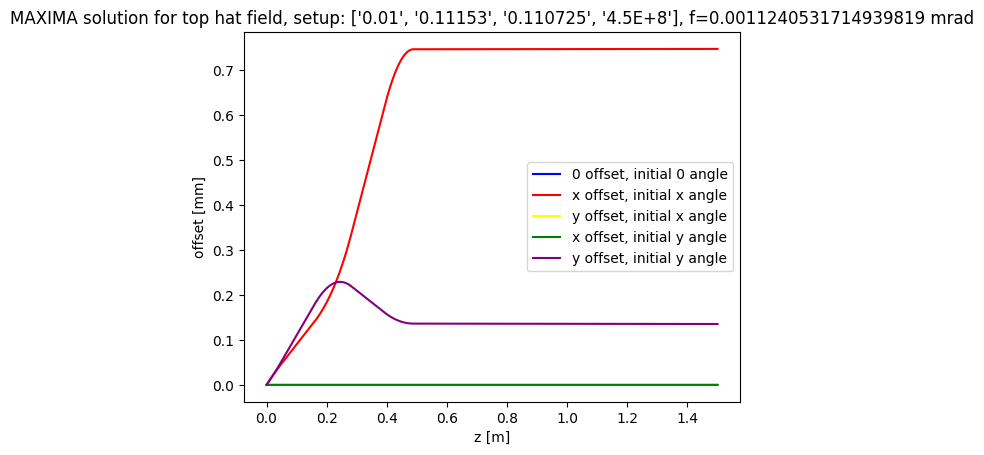

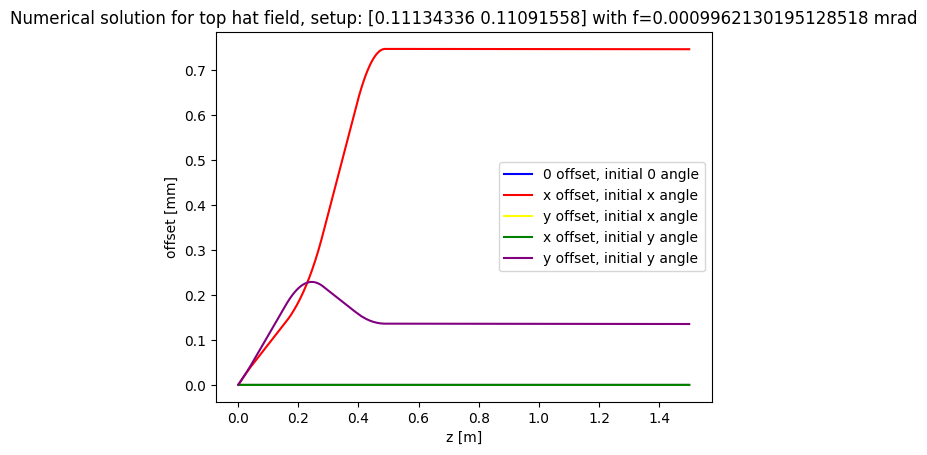

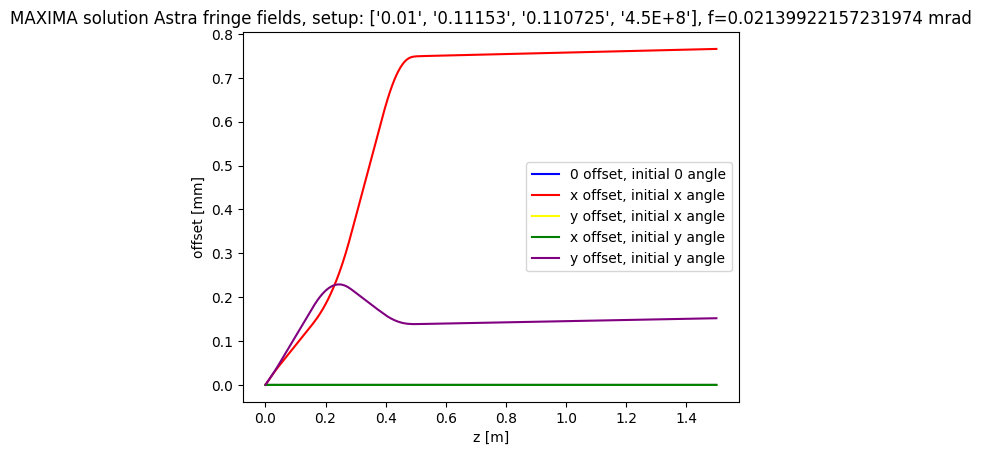

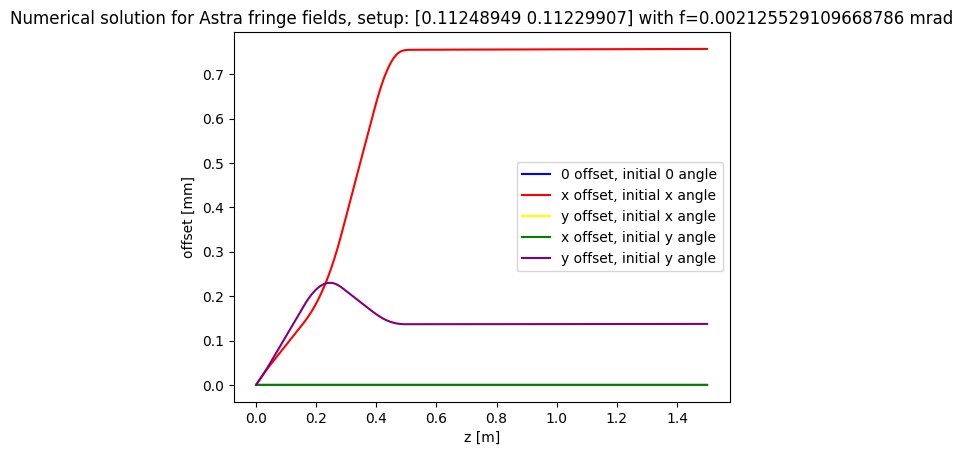

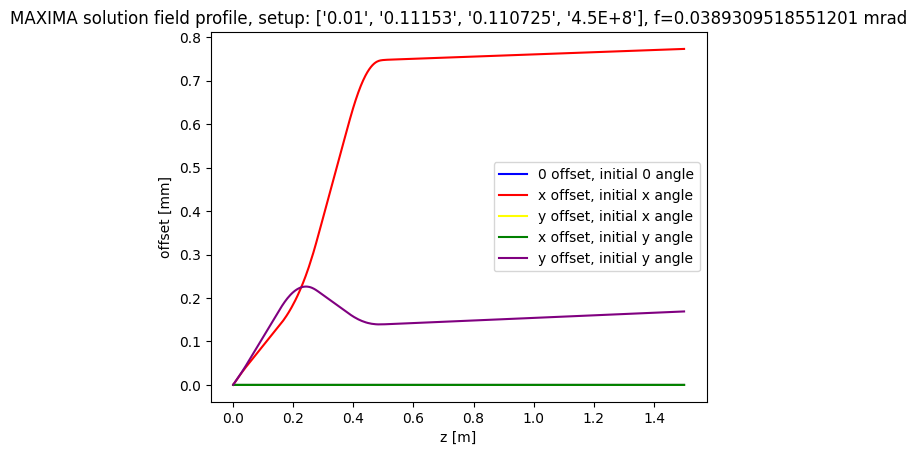

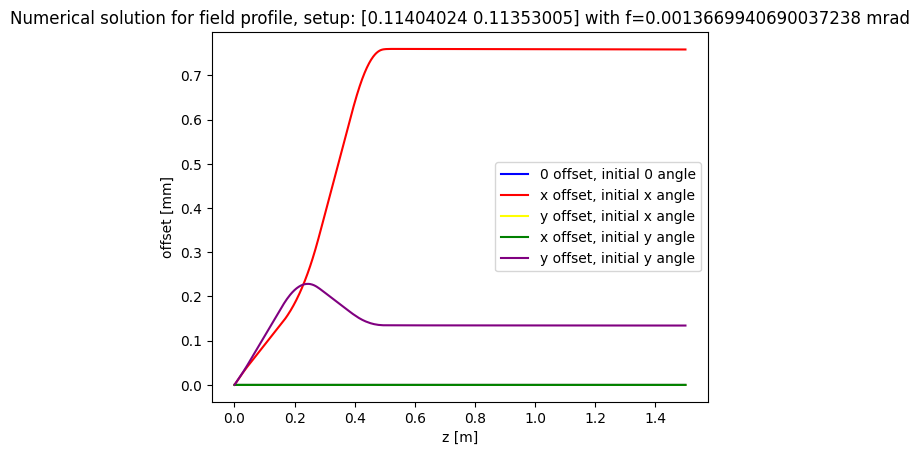

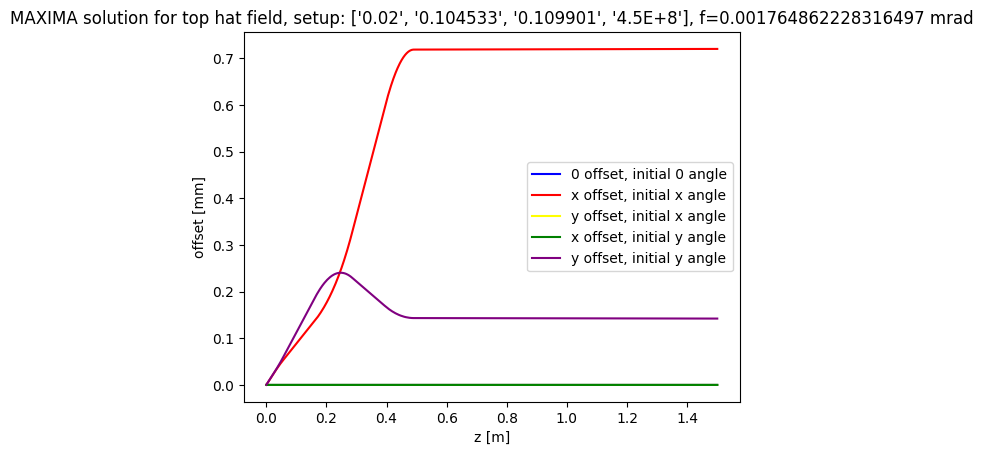

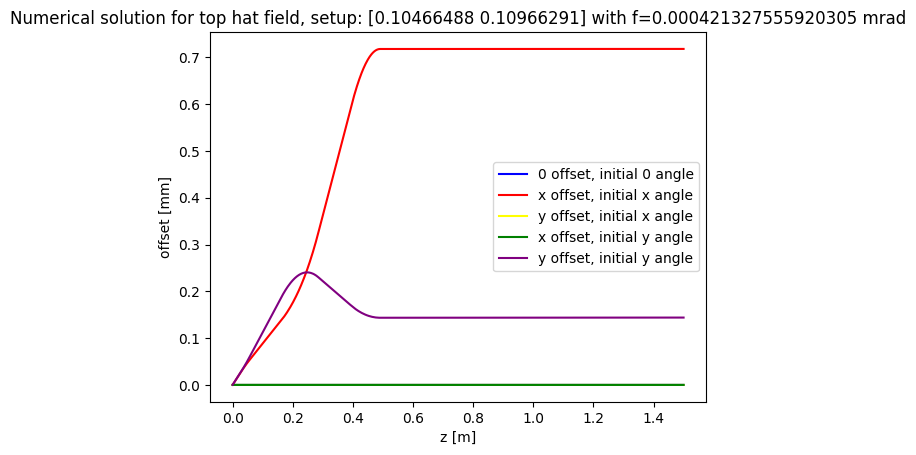

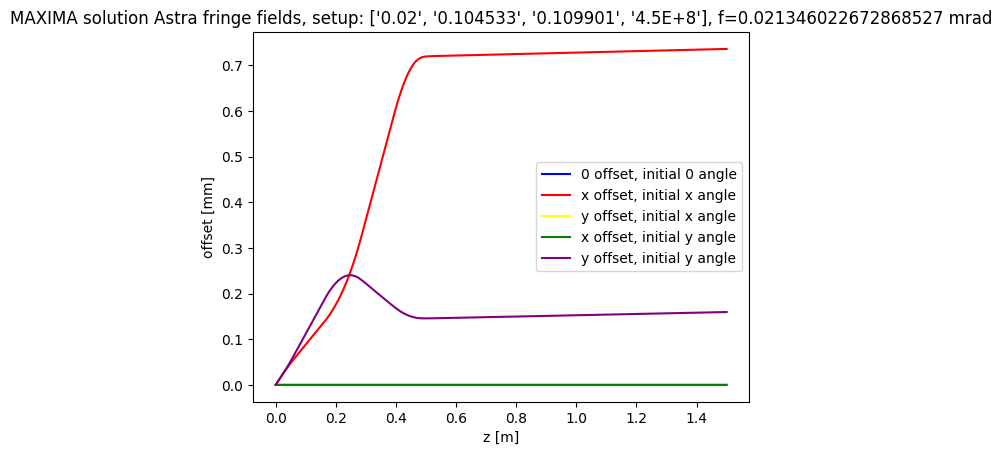

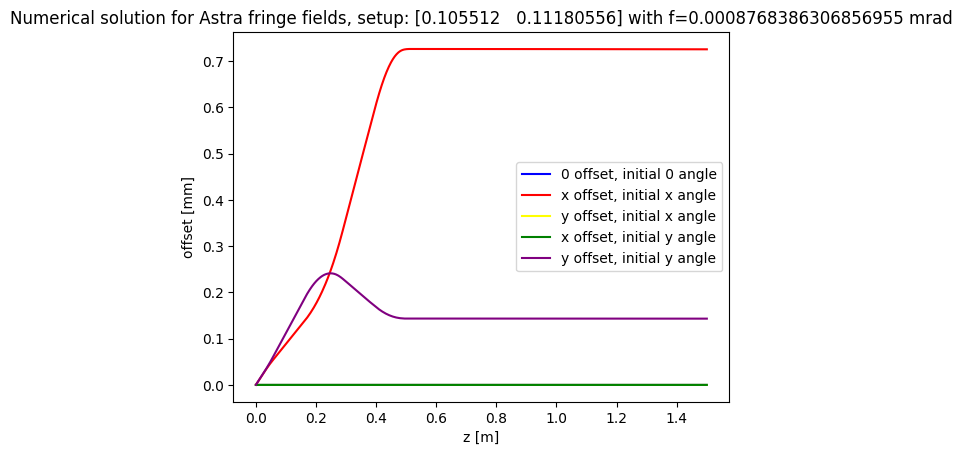

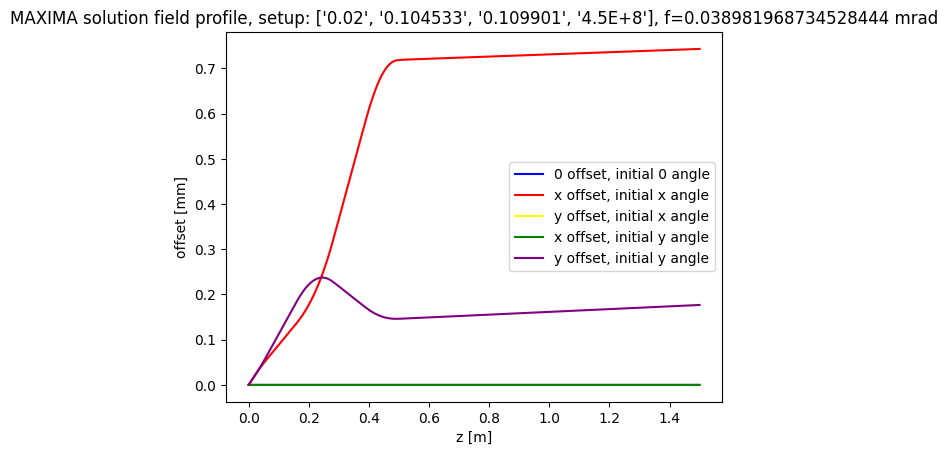

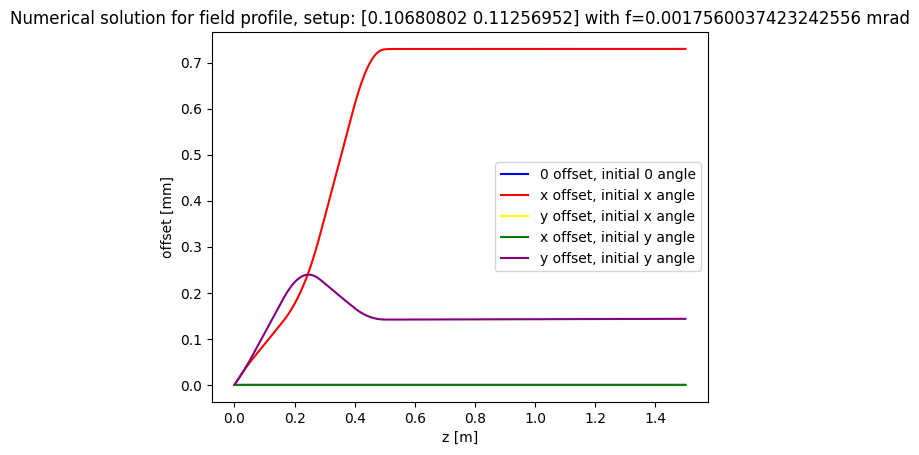

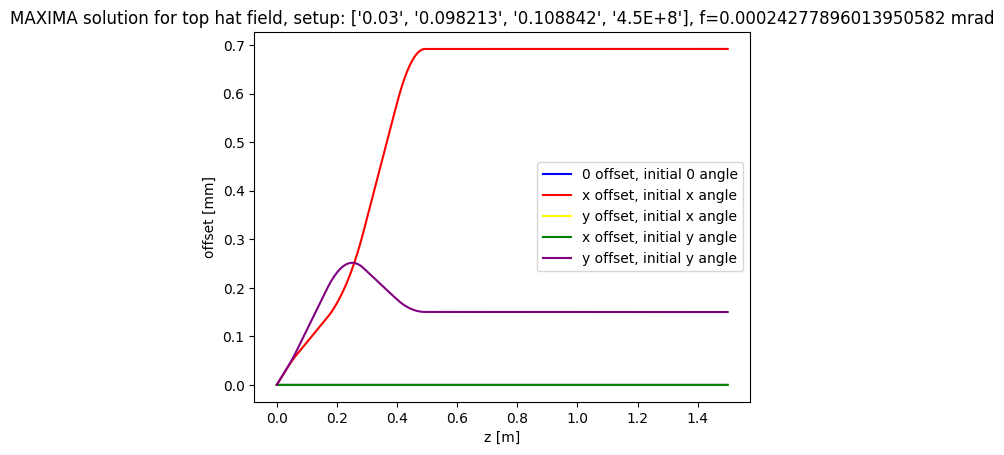

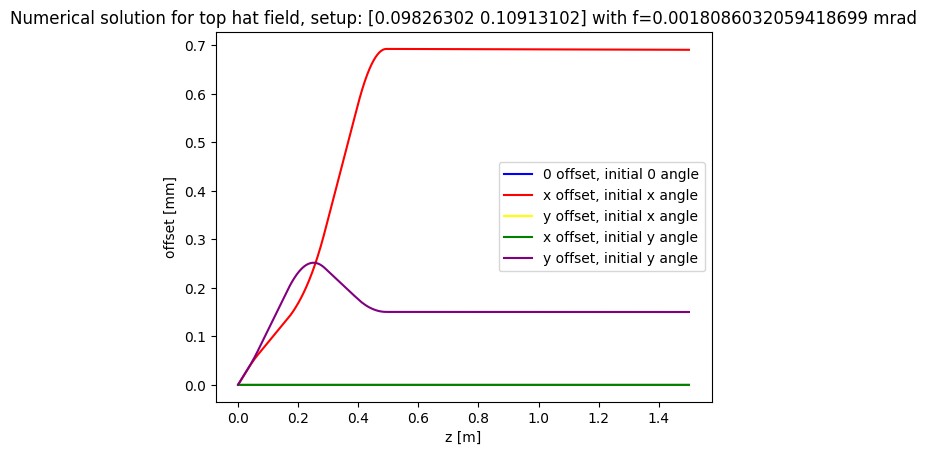

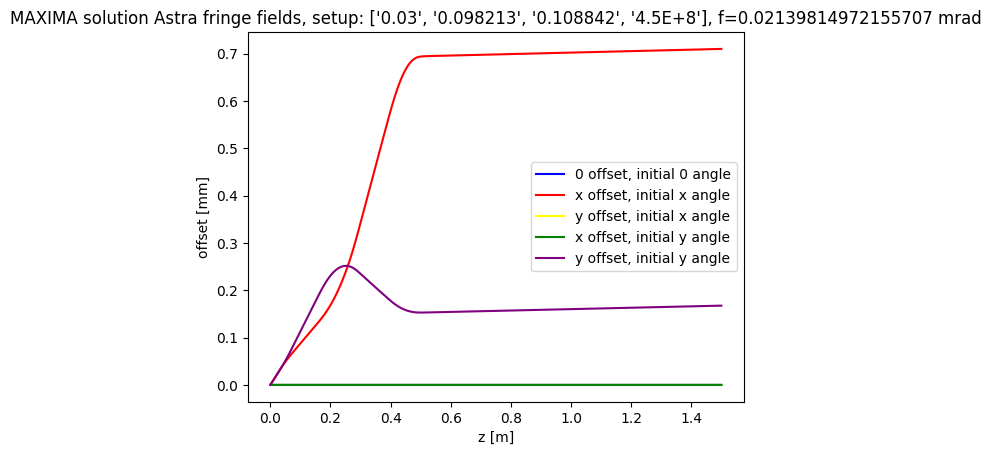

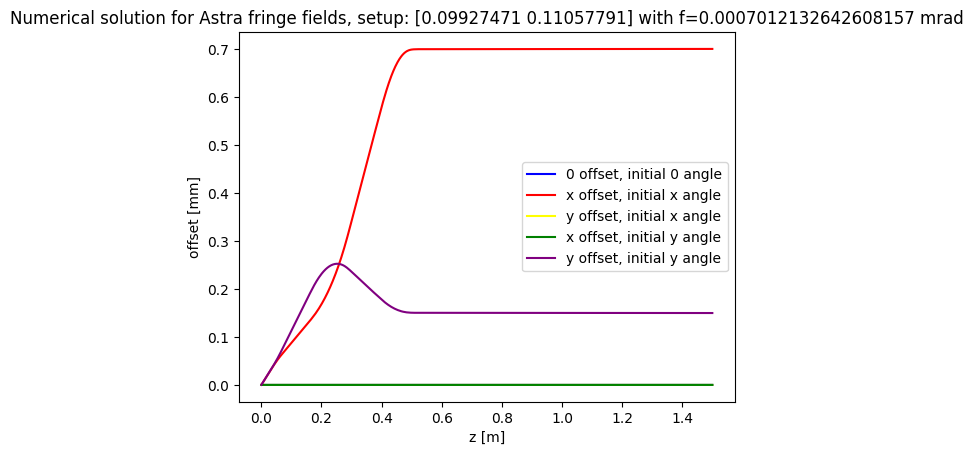

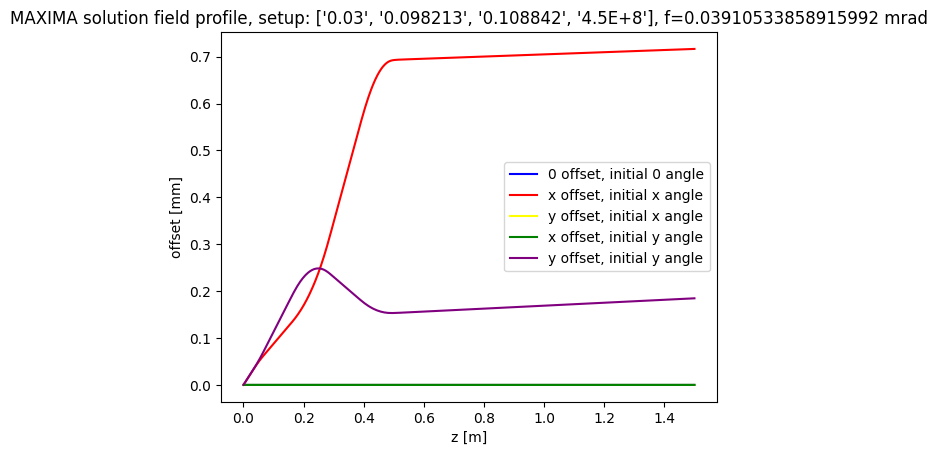

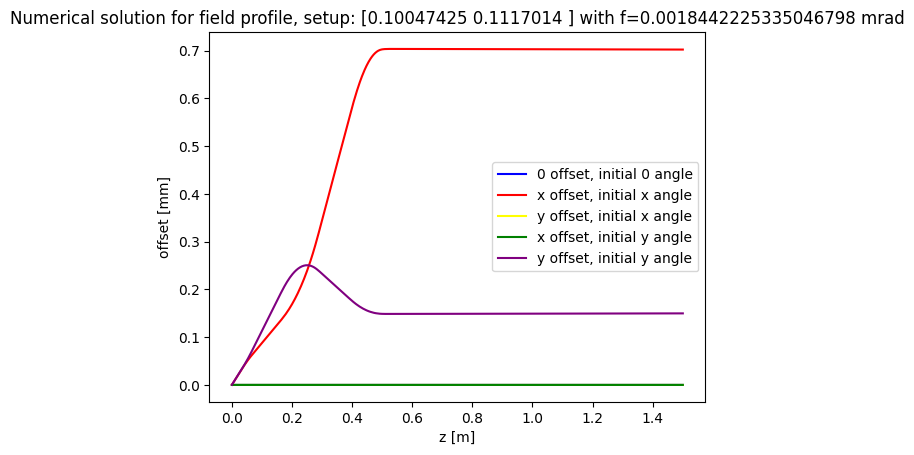

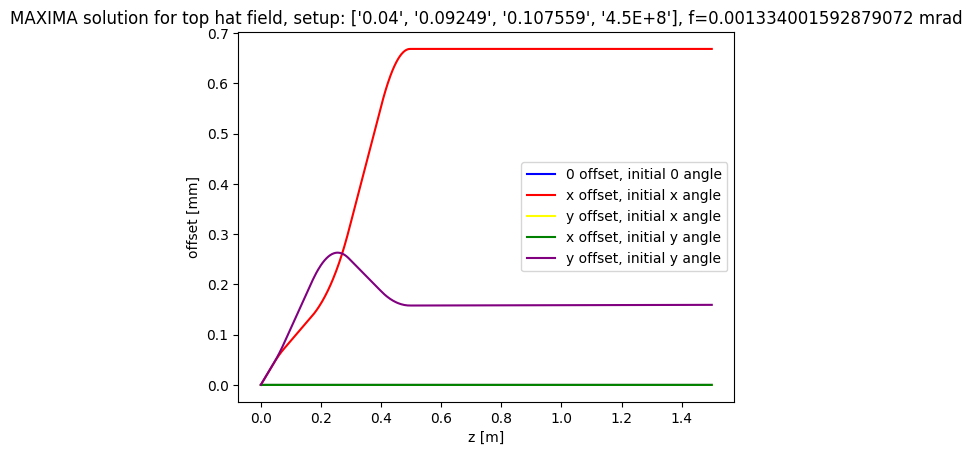

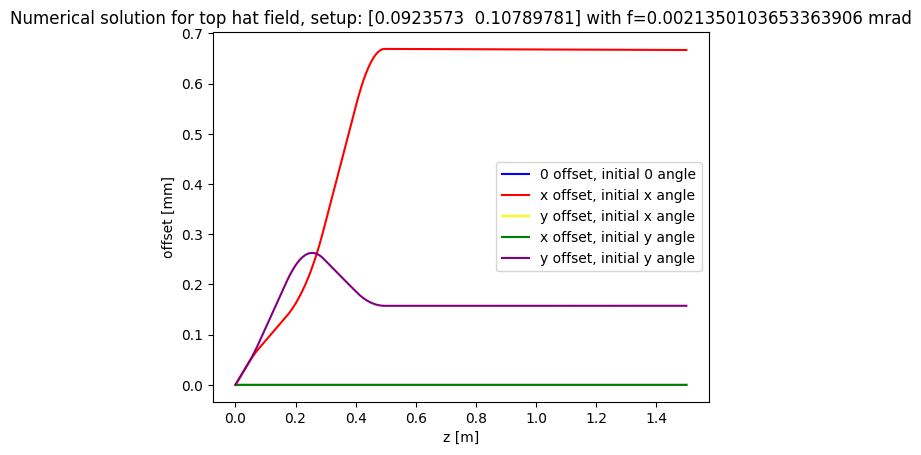

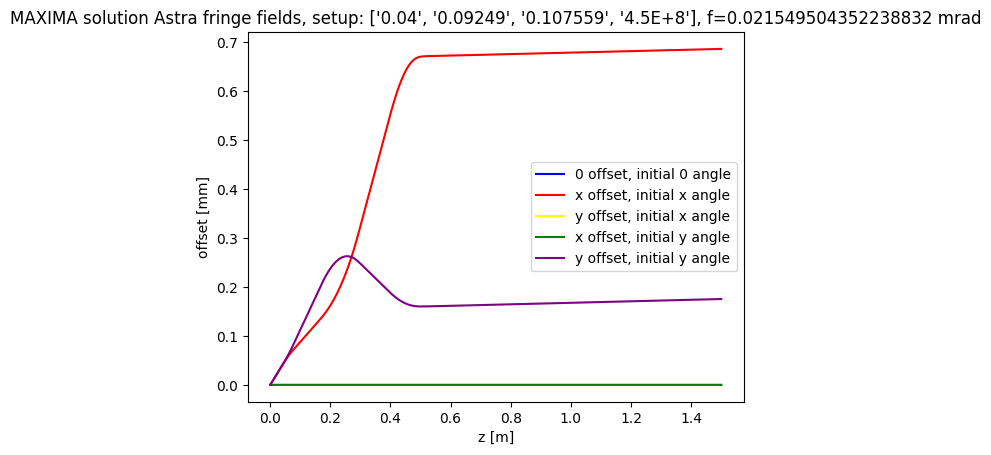

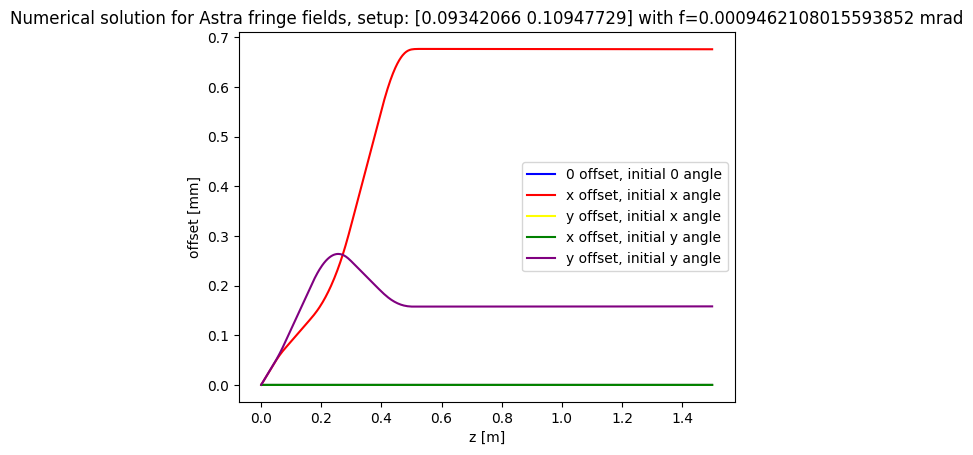

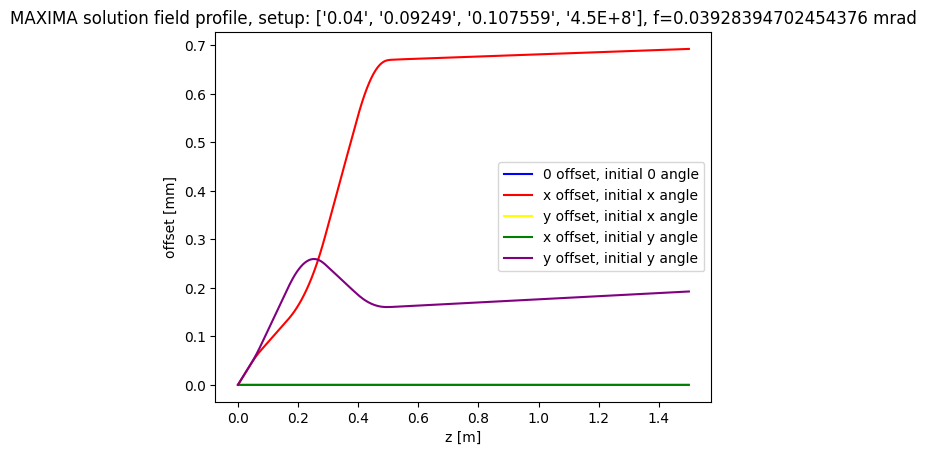

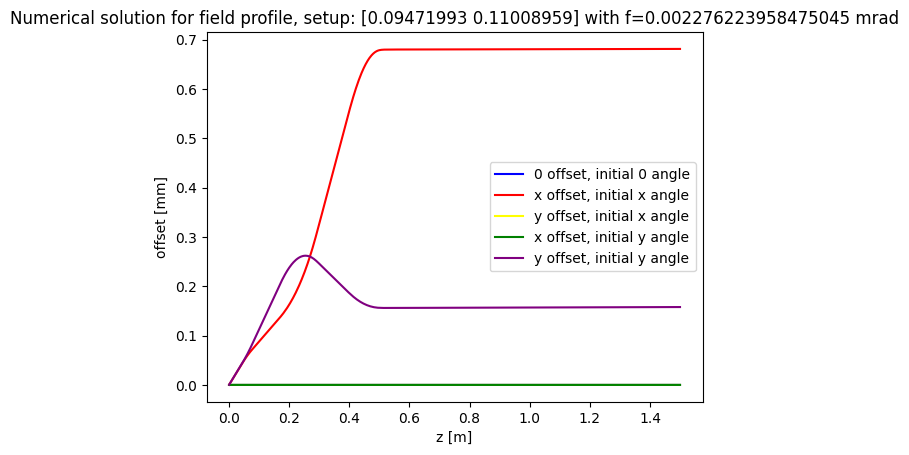

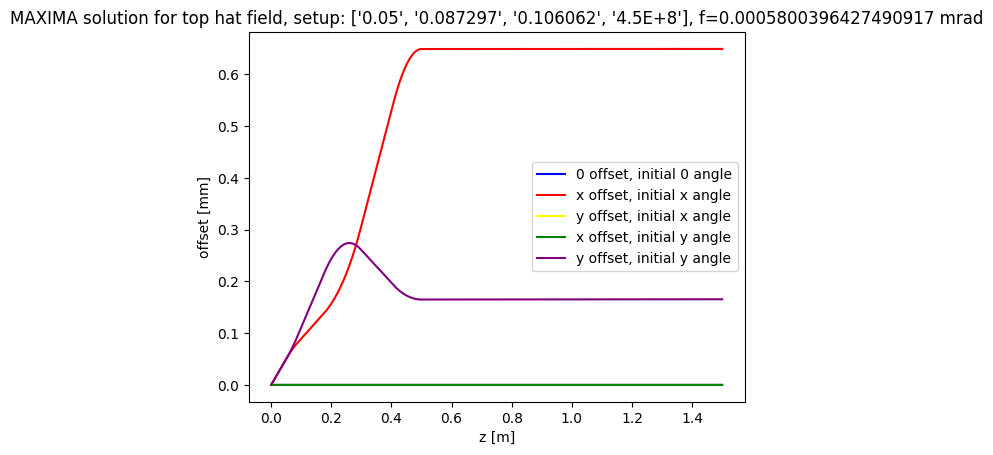

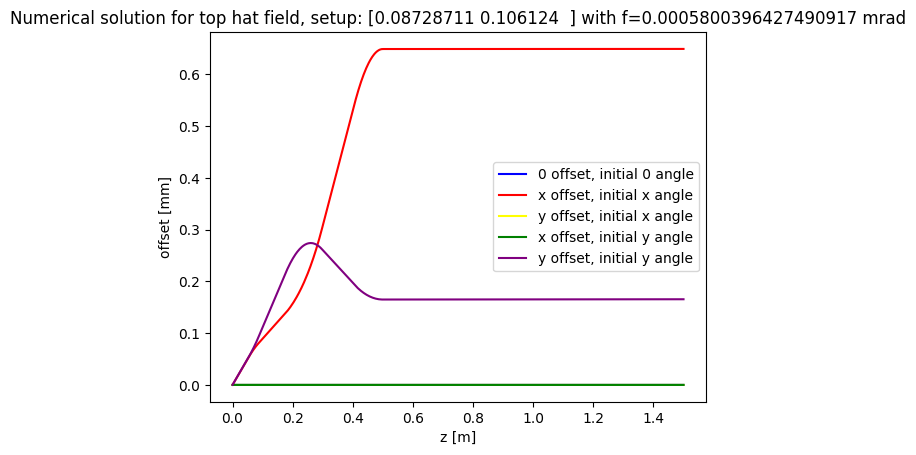

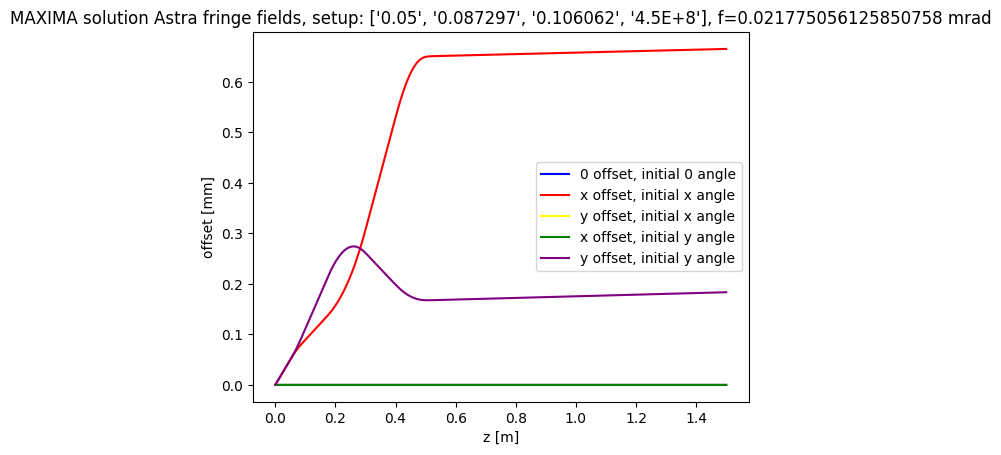

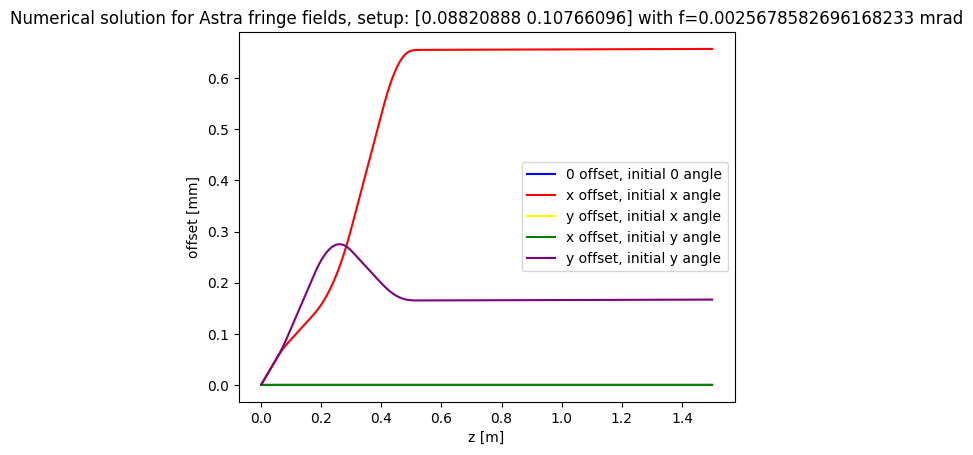

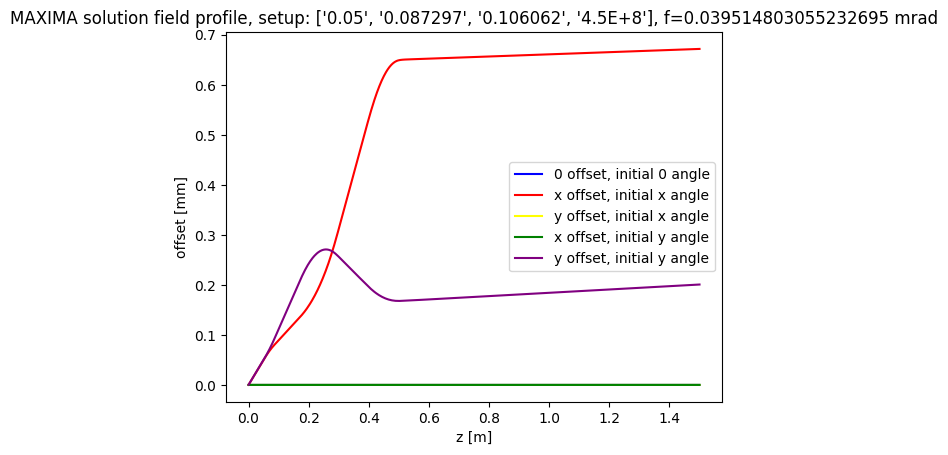

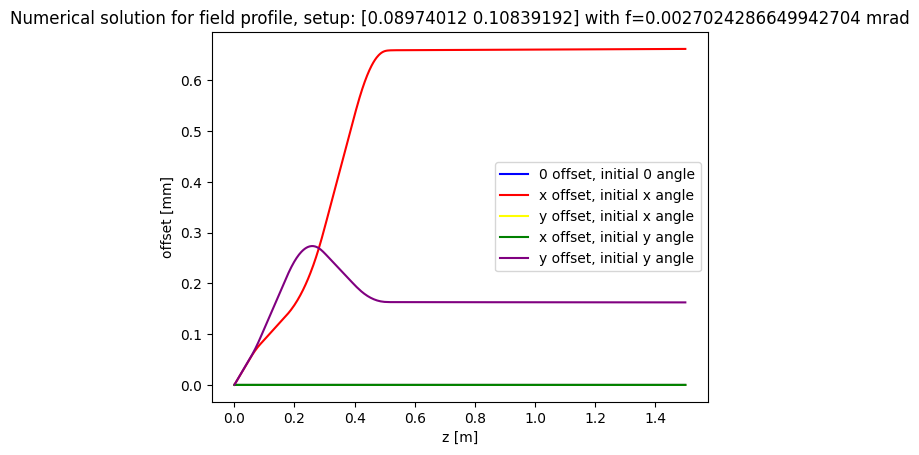

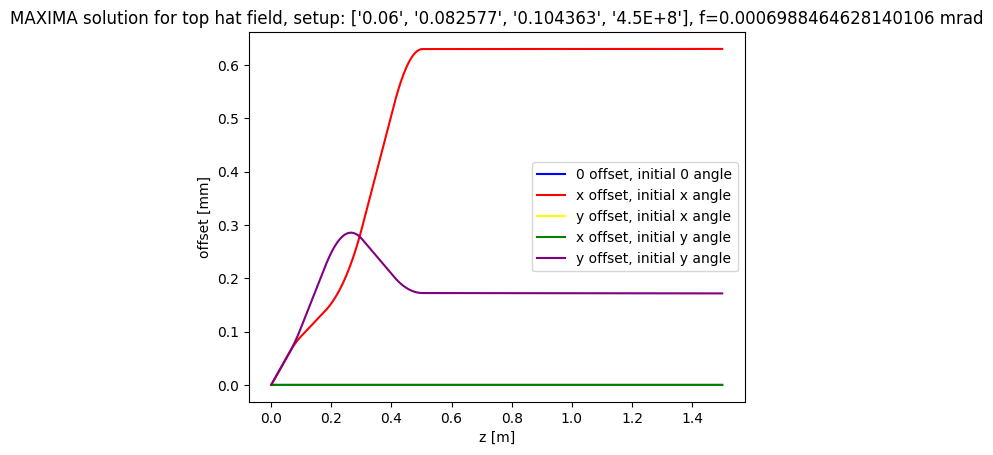

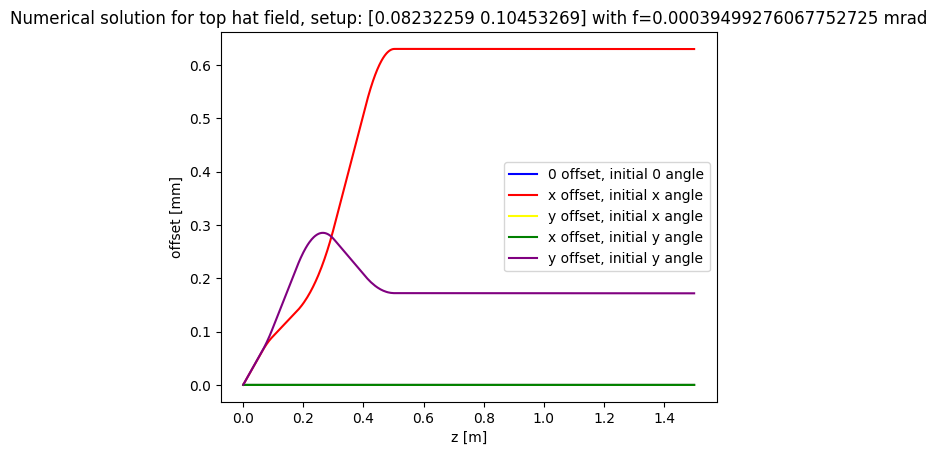

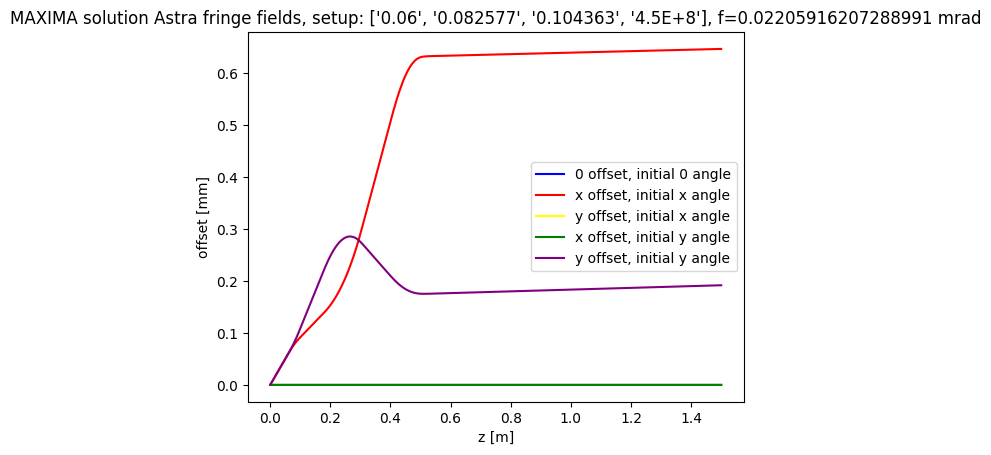

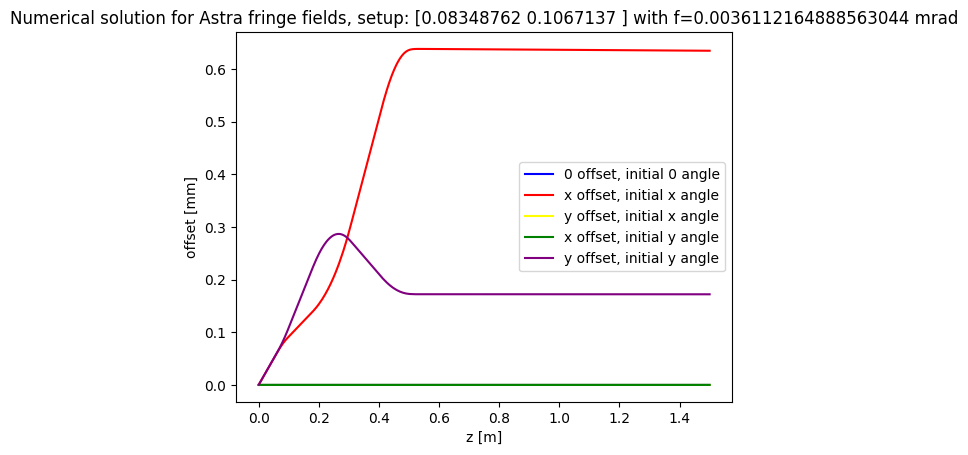

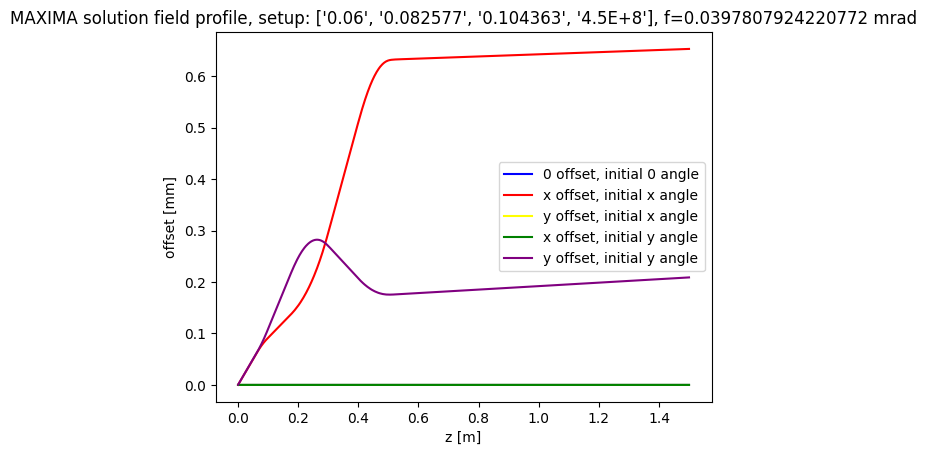

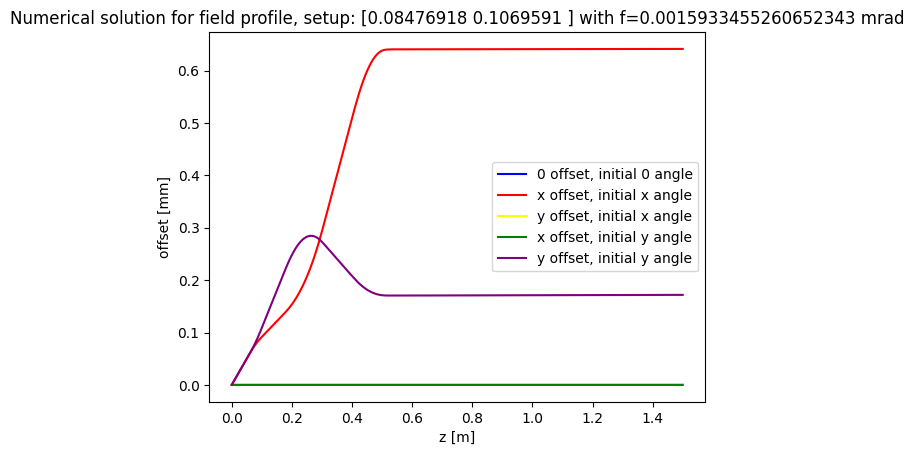

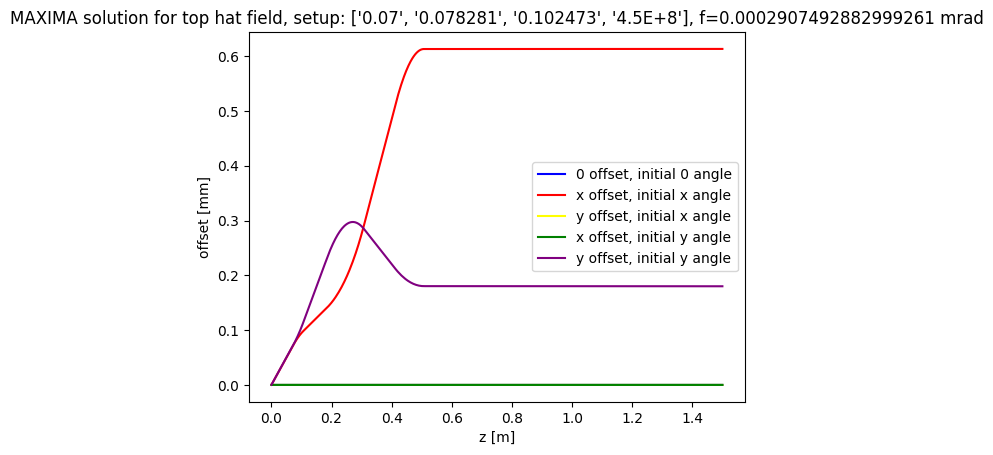

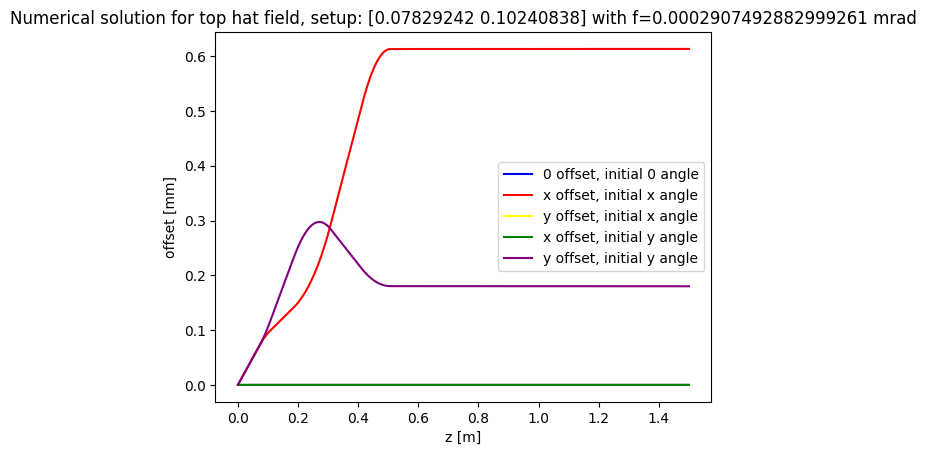

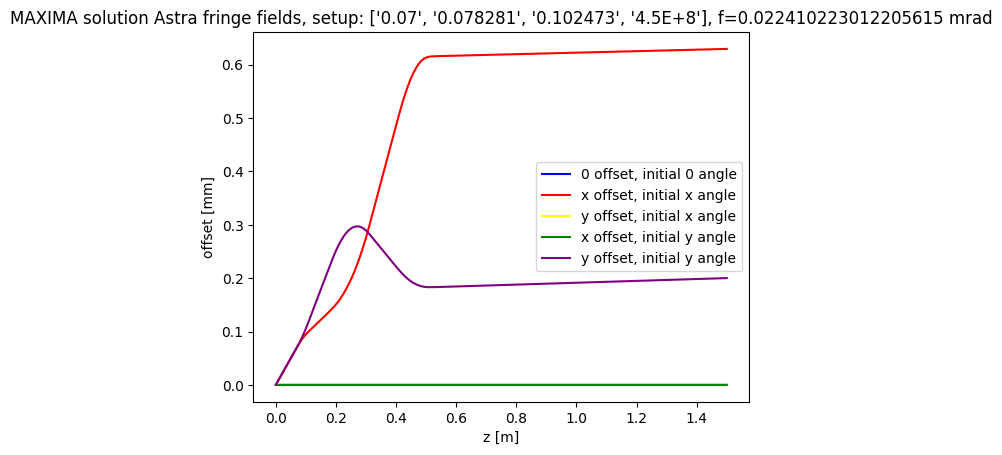

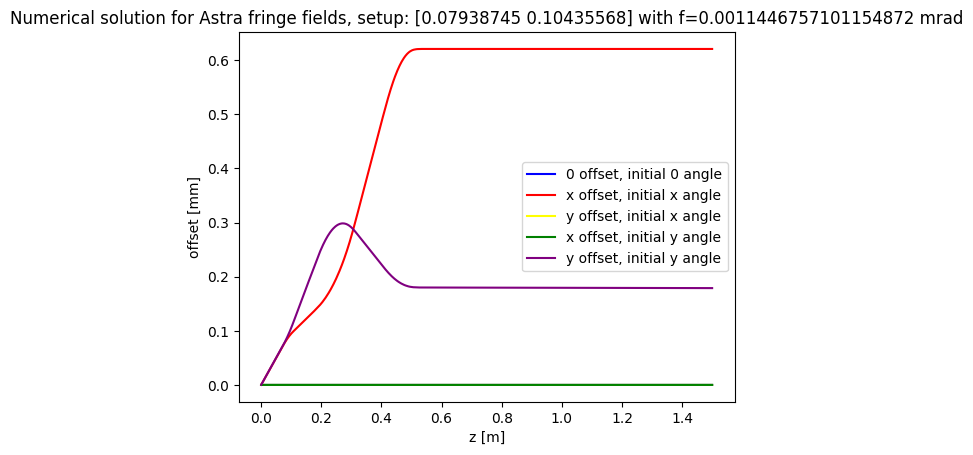

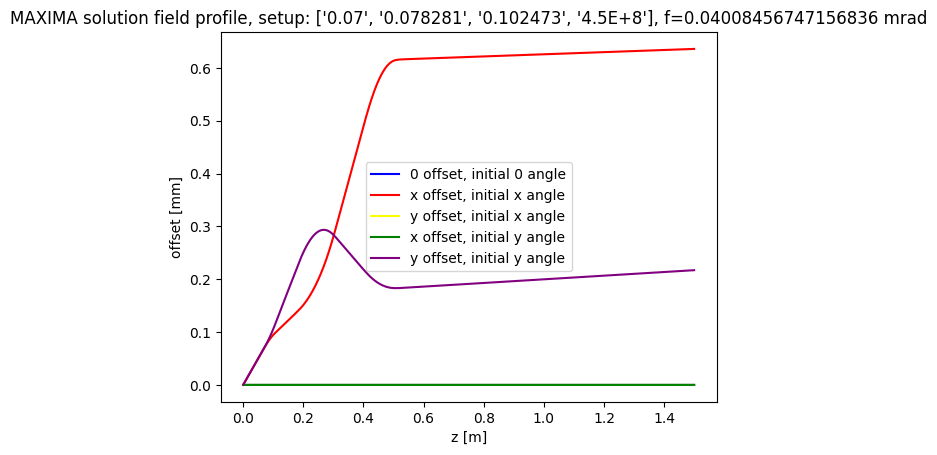

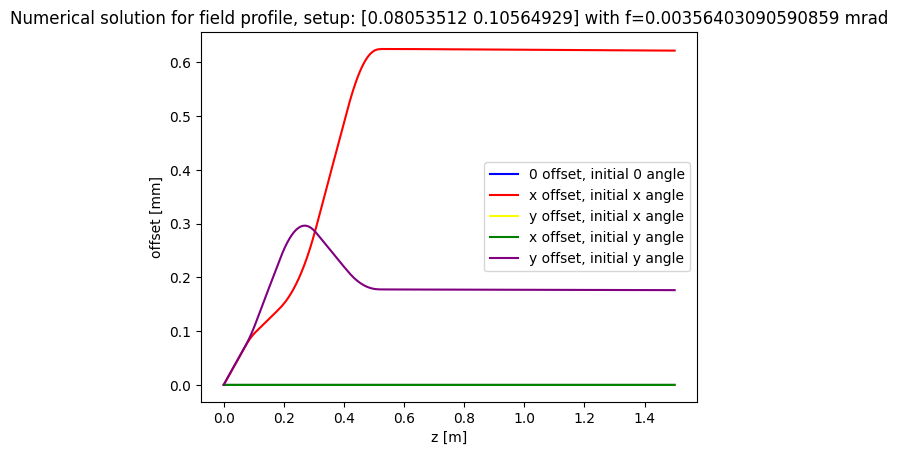

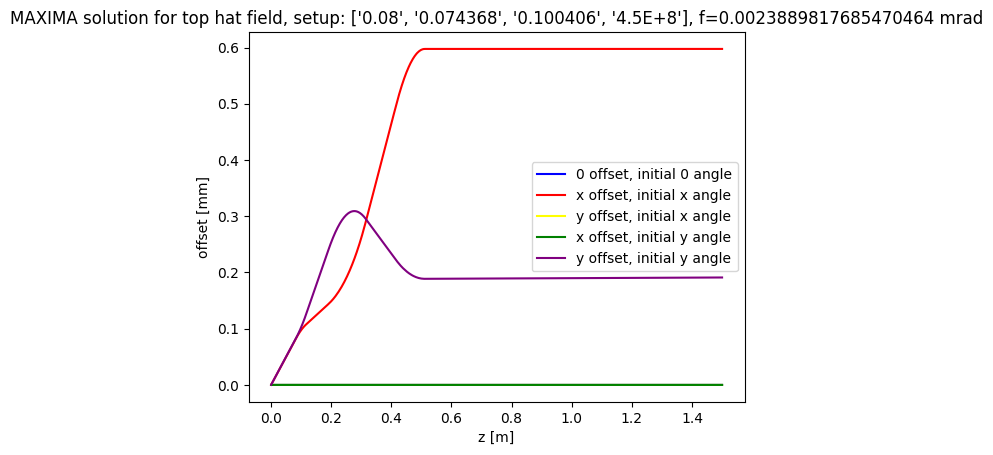

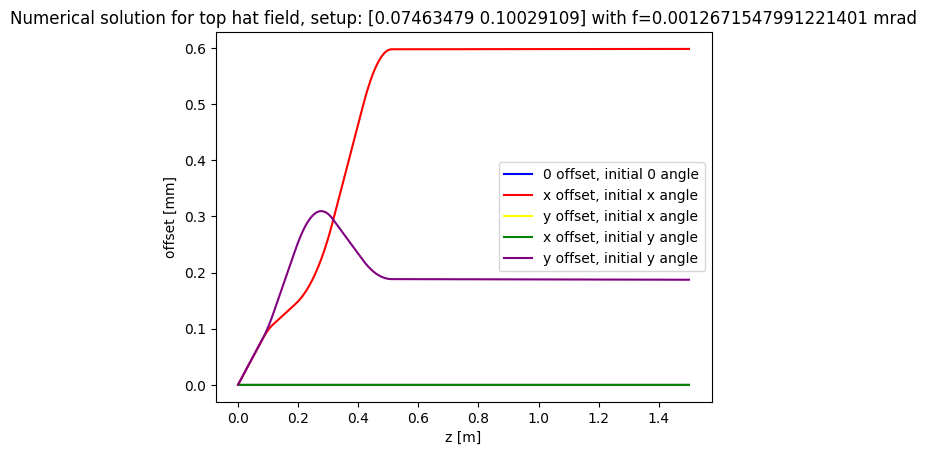

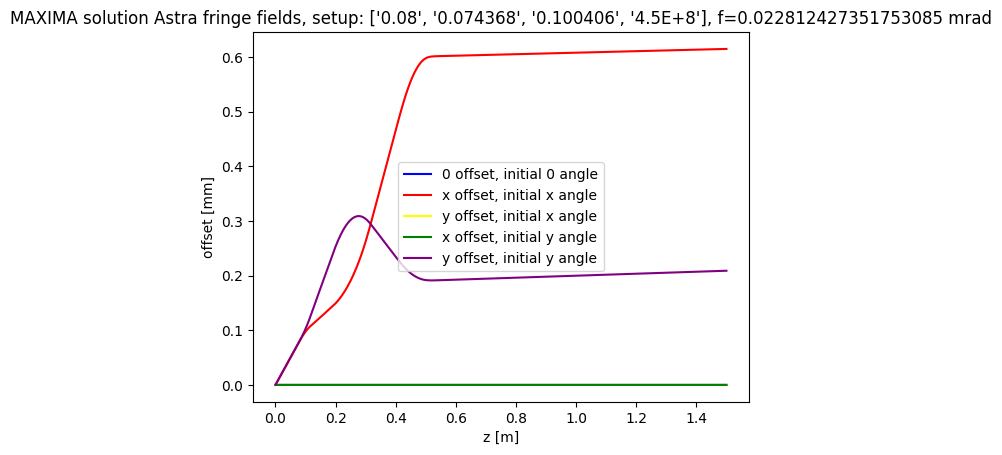

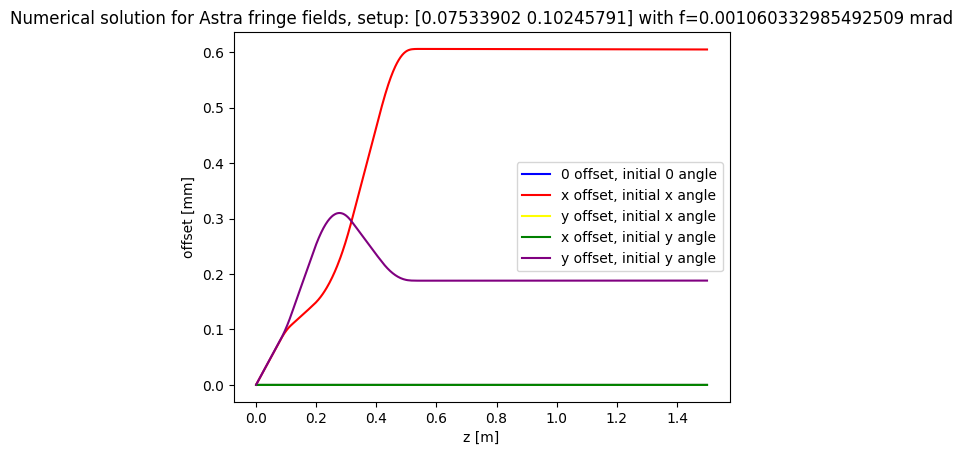

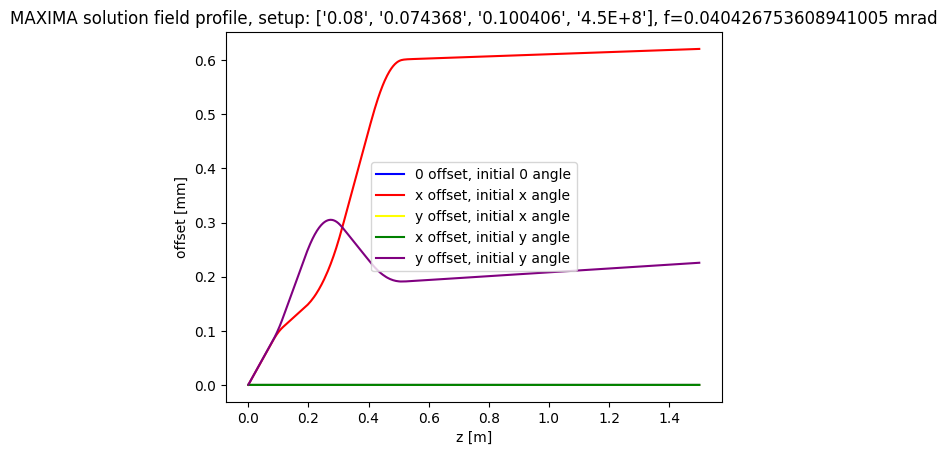

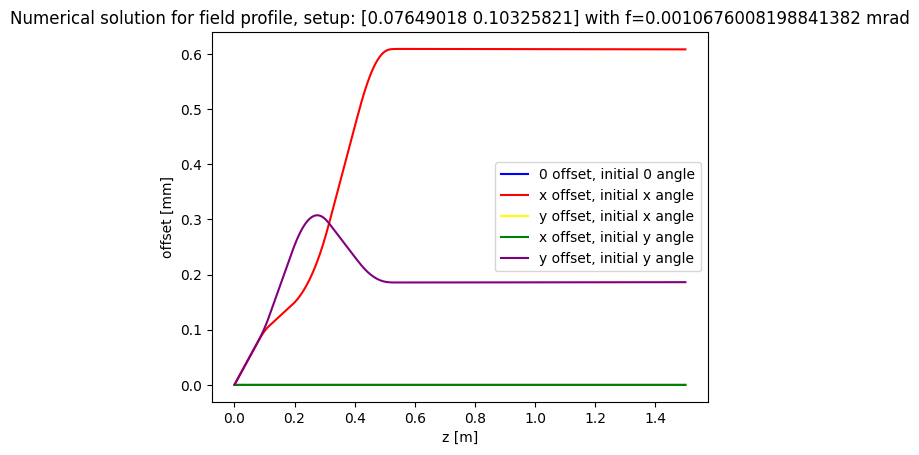

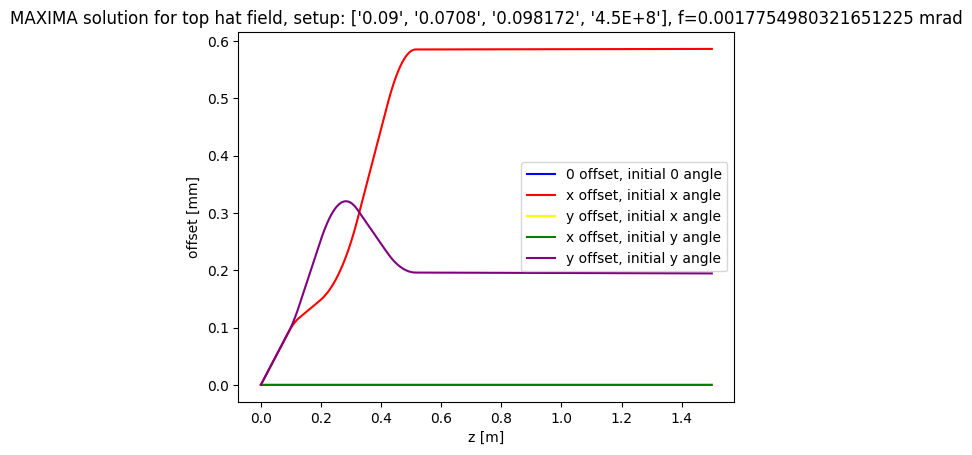

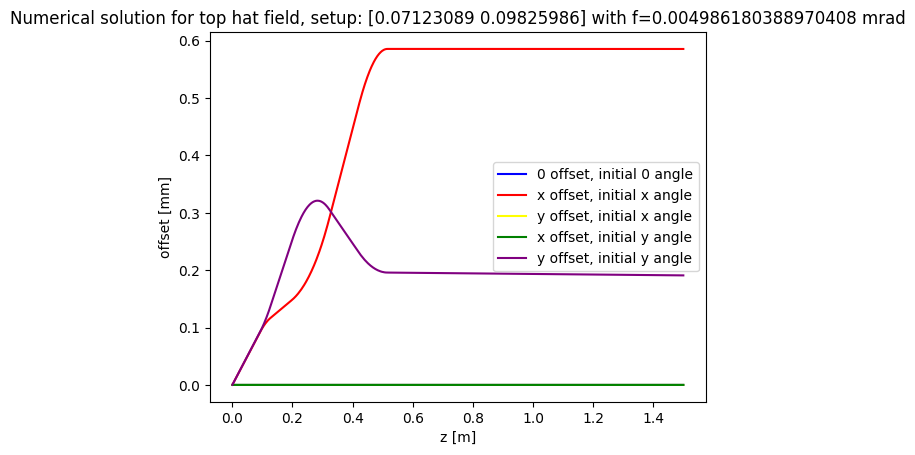

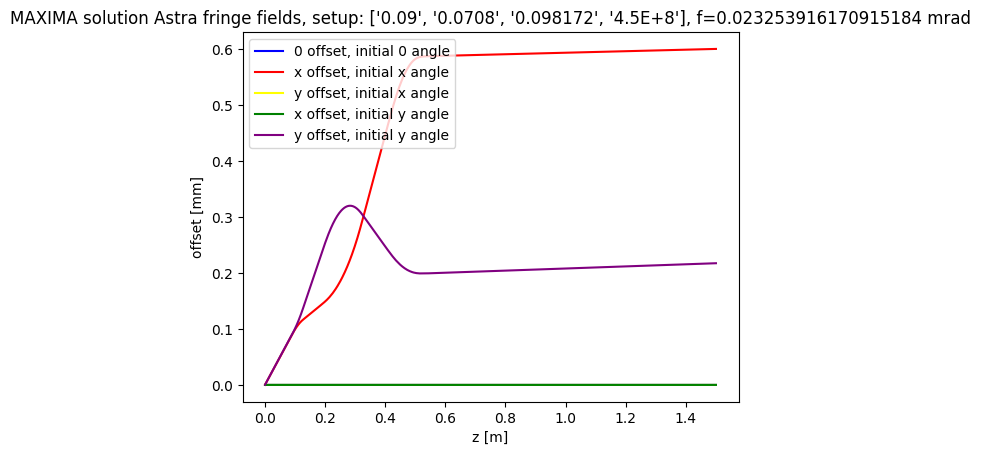

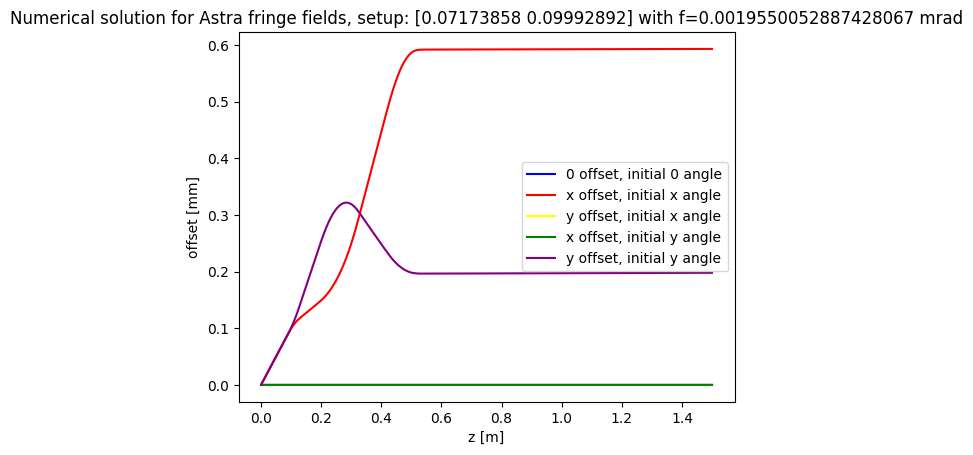

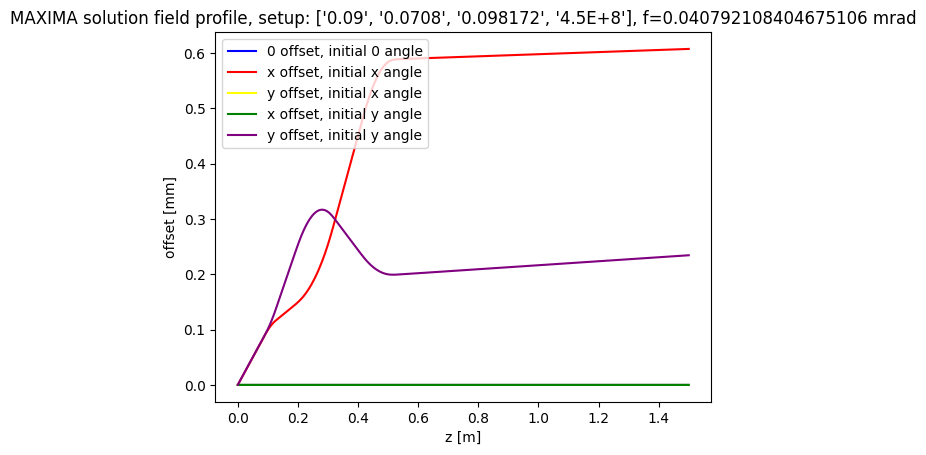

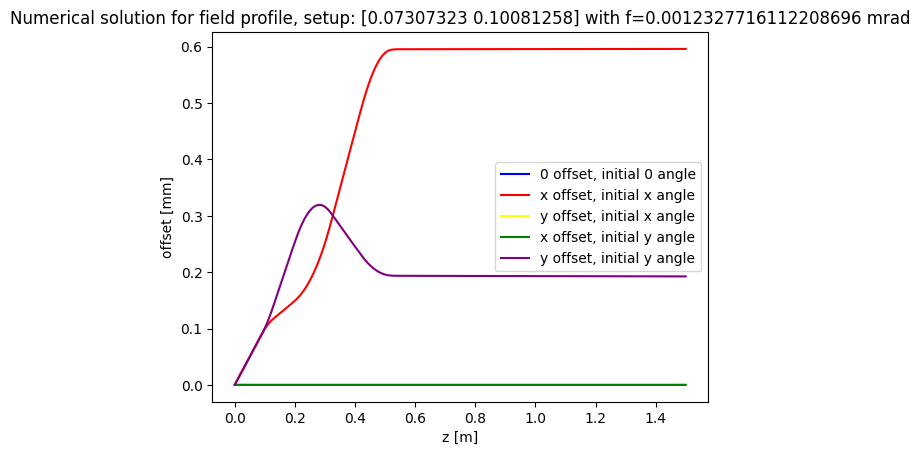

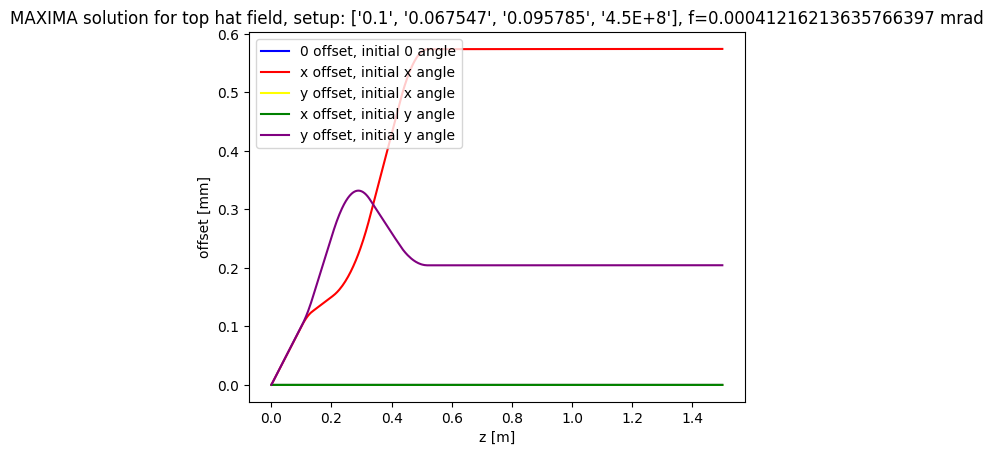

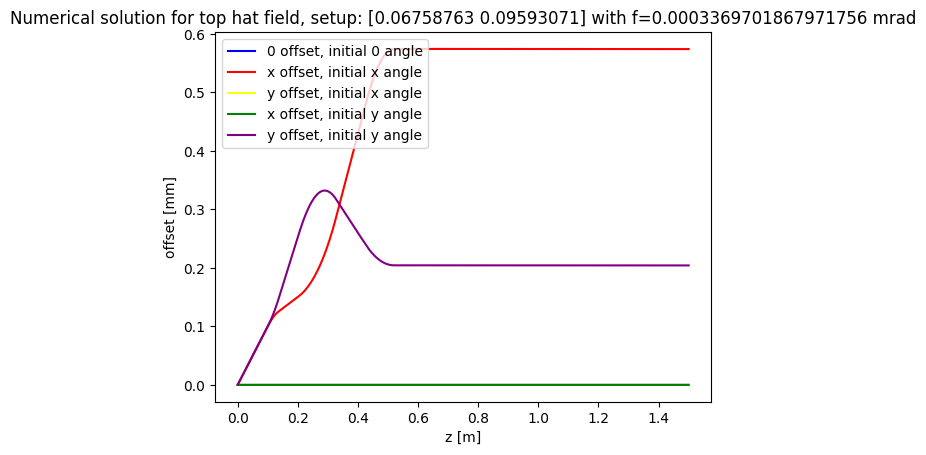

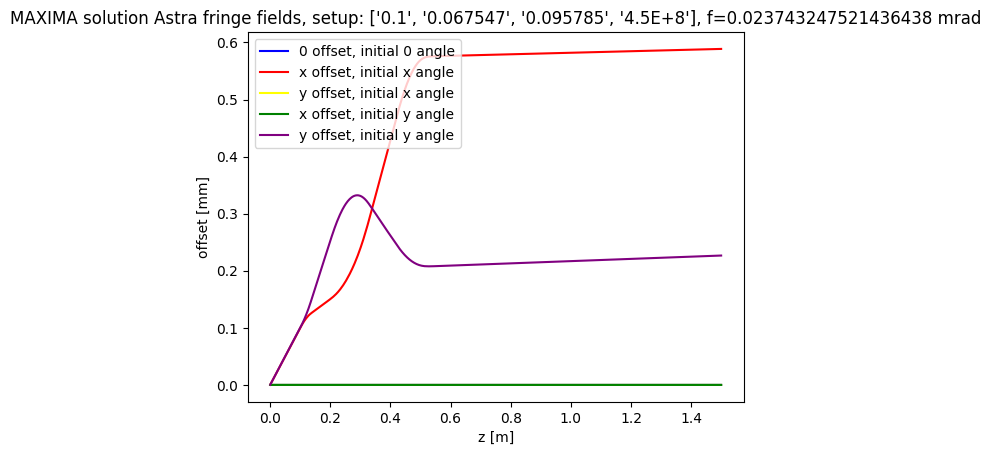

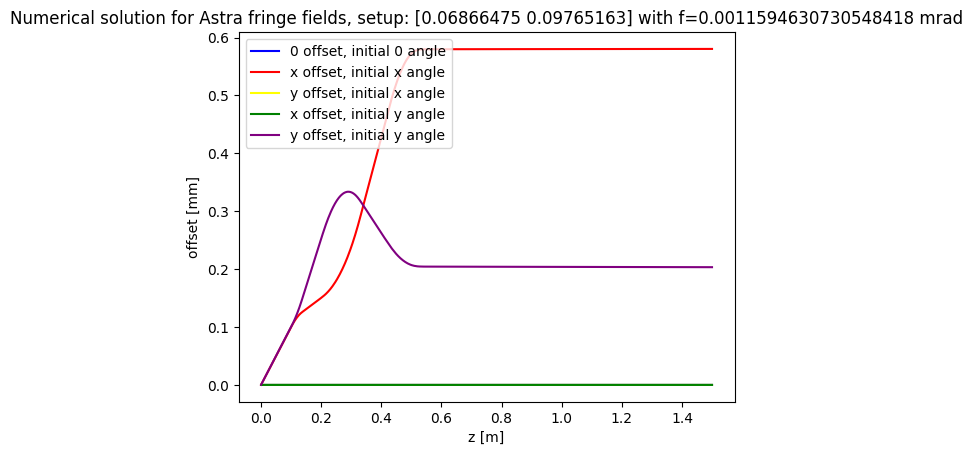

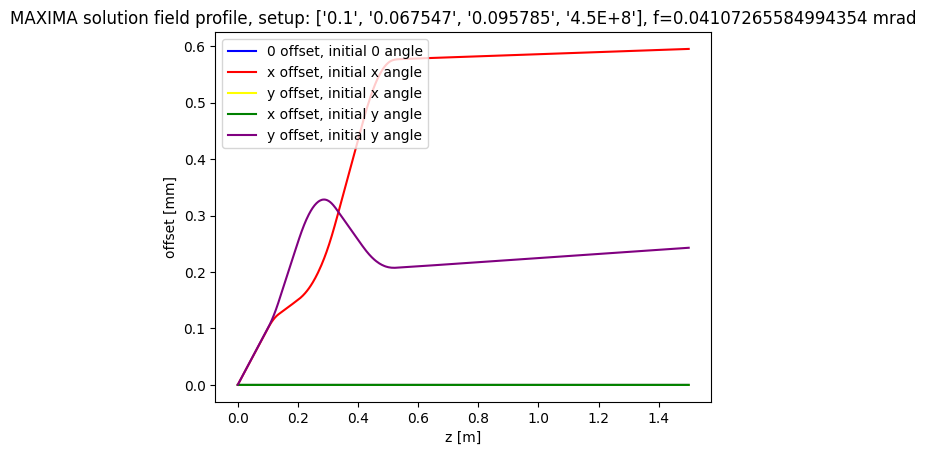

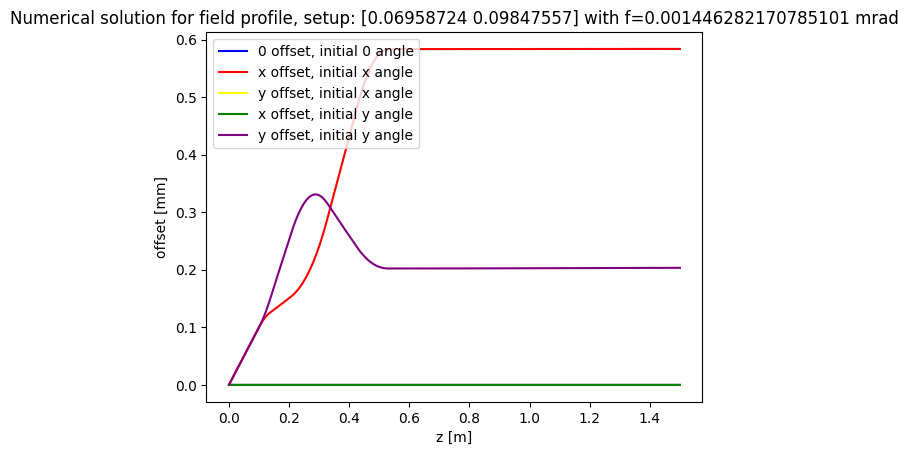

,0,1,2,3,4,5,6,7,8,9
0,0.01,0.11153,0.110725,4.5E+8,0.001124,0.000996,0.021399,0.002126,0.038931,0.001367
1,0.02,0.104533,0.109901,4.5E+8,0.001765,0.000421,0.021346,0.000877,0.038982,0.001756
2,0.03,0.098213,0.108842,4.5E+8,0.000243,0.001809,0.021398,0.000701,0.039105,0.001844
3,0.04,0.09249,0.107559,4.5E+8,0.001334,0.002135,0.021550,0.000946,0.039284,0.002276
4,0.05,0.087297,0.106062,4.5E+8,0.000580,0.000580,0.021775,0.002568,0.039515,0.002702
5,0.06,0.082577,0.104363,4.5E+8,0.000699,0.000395,0.022059,0.003611,0.039781,0.001593
6,0.07,0.078281,0.102473,4.5E+8,0.000291,0.000291,0.022410,0.001145,0.040085,0.003564
7,0.08,0.074368,0.100406,4.5E+8,0.002389,0.001267,0.022812,0.001060,0.040427,0.001068
8,0.09,0.0708,0.098172,4.5E+8,0.001775,0.004986,0.023254,0.001955,0.040792,0.001233
9,0.1,0.067547,0.095785,4.5E+8,0.000412,0.000337,0.023743,0.001159,0.041073,0.001446


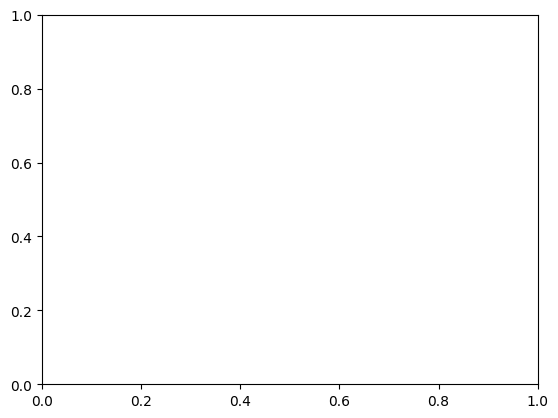

In [57]:
'''
args = sys.argv
args.pop(0)
if len(args) != 1:
    print(f"more than 1 argument")
file = args[0]
'''
file = "../../MAXIMA/analyticalResultsP.txt"
study(file)



In [72]:
def comparisonAnaNum(setupFileName, minimalFunVal):

    update()
    #boundaries for D2, D3    
    Dmin = [0.0,0.0]
    Dmax = [0.3,0.3]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]

    
    with open("../../MAXIMA/" + setupFileName, "r") as file:
        stringdata = file.readlines()
        
    analyticData = []
    for line in stringdata:
        line = line.replace("\n","")
        line = line.split(" ")  
        analyticData.append(line)

    '''
    resultsTable = {
        "" : ["D1 [m]", "D2 [m]", "D3 [m]", "Pz [eV]", 
              "F_ana [mrad]", "F_num [mrad]", 
              "Delta D2 [mm]" , "Delta D3 [mm]",
              "setup length [m]", 
              "Angle accept. x [mrad]", "Angle accept. y [mrad]",
              "beam size x [mm]", "beam size y [mm]","beam ratio [-]",
              "active particles for sig_xyAngle = 1 mrad [%],
              "number of func. evaluations [-]",
              "x angle [mrad], y angle [mrad]",
             ]
    }
    '''
    finalTable = []
    
    resultSetups = ""
    errorSetups = ""
    initialAng = []
    
    for row in analyticData:
        #first run the analytical solution and show plots
        topHatShapedQuads(True)
        changeMom(sig_xAngle, sig_yAngle, float(row[3]), -1, -1)
        
        sumAna = angleCalculation(runRef(float(row[0]),float(row[1]), float(row[2]), float(row[3]), False))
        plotRefXY1(float(row[0]),float(row[1]), float(row[2]), float(row[3]), f"Analytic results, '{row}', top hat fields")
        
        res = sc.optimize.minimize(func, (0.15, 0.15),method="Powell", bounds=bounds,tol=1e-6, args=(float(row[0]), float(row[3])))
        #res = sc.optimize.minimize(func, (0.15, 0.15), method="Powell", bounds=bounds, options={'ftol': 1e-8}, args=(float(row[0]), float(row[3])))
        #res = sc.optimize.minimize(func, (0.15, 0.15), method="Powell", bounds=bounds, options={'xtol': 1e-8}, args=(float(row[0]), float(row[3])))

        if not res.success or res.fun > minimalFunVal:
            print(f"Could not find numerical solution for d1 = {row[0]} and pz = {row[3]}. Skipping.")
            errorSetups += row[0] + " " + row[1] + " " + row[2] + " " + row[3] + "\n"
            continue
        
        sumNum = angleCalculation(runRef(float(row[0]),*res.x , float(row[3]), False))
        plotRefXY1(float(row[0]),*res.x, float(row[3]), f"Numerical results, ['{row[0]}', '{res.x[0]}', '{res.x[1]}', '{row[3]}'], top hat fields")
        resultSetups += row[0] + " " + str(res.x[0]) + " " + str(res.x[1]) + " " + row[3] + "\n"
        row.append(sumAna)
        row.append(sumNum)
        
        DeltaD2 = math.fabs(float(row[1]) - res.x[0])*1000 
        DeltaD3 = math.fabs(float(row[2]) - res.x[1])*1000
        row.append( DeltaD2 )
        row.append( DeltaD3 )
        
        row.append( setupSize(float(row[0]), *res.x ))
        angleAcceptance = checkAngleAcceptance(float(row[0]), *res.x, float(row[3]))
        row.append(angleAcceptance[0])
        row.append(angleAcceptance[1])
        row.append(angleAcceptance[2])
        row.append(angleAcceptance[3])
        row.append(angleAcceptance[2]/angleAcceptance[3])
        row.append(angleAcceptance[4])
        row.append(res.nfev)
        finalTable.append(row)
        

    print(resultSetups)
    print(errorSetups)
    if resultSetups != "":
        with open("results.txt", "w") as file:
            file.write(resultSetups)
    if errorSetups != "":
        with open("errors.txt","w") as file:
            file.write(errorSetups)

    
    return finalTable

In [73]:
def plotResultsAcceptance(file, file2):

    df = pd.read_csv(file)
    list = df.values.tolist()

    data = []
    for i in range(160):
        data.append(list[i*18])

    
    for i in range(10):
        D1 = [value[0] for value in data[i*16:(i+1)*16]]        
        Pz = [value[3]*1e-6 for value in data[i*16:(i+1)*16]]
        acceptX = [value[4] for value in data[i*16:(i+1)*16]]
        acceptY = [value[5] for value in data[i*16:(i+1)*16]]

        plt.scatter(Pz, acceptX, color='blue', label='acceptance X')
        plt.scatter(Pz, acceptY, color='red', label='acceptance Y')
        plt.legend()
        plt.xlabel("Pz [MeV]")
        plt.ylabel("acceptance [mrad]")
        plt.title(f"Plot of acceptances w.r.t. momentum for D1 = {i +1} cm")
        plt.show()

    
    df = pd.read_csv(file2)
    list = df.values.tolist()

    data = []
    for i in range(160):
        data.append(list[i*18])

    for i in range(16):
        D1 = [value[0]*1e+2 for value in data[i*10:(i+1)*10]]
        Pz = [value[3]*1e-6 for value in data[i*10:(i+1)*10]]
        acceptX = [value[4] for value in data[i*10:(i+1)*10]]
        acceptY = [value[5] for value in data[i*10:(i+1)*10]]

        plt.scatter(D1, acceptX, color='blue', label='acceptance X')
        plt.scatter(D1, acceptY, color='red', label='acceptance Y')
        plt.legend()
        plt.xlabel("D1 [cm]")
        plt.ylabel("acceptance [mrad]")
        plt.title(f"Plot of acceptances w.r.t. D1 for Pz = {250 + i*50} MeV")
        plt.show()

    



In [74]:
def plotResultsSigmaSpread(file):


    df = pd.read_csv(file)
    data = df.values.tolist()

    #results = D1, D2, D3, momZ, xAccept, yAccept,xAng_sig, yAng_sig, beam size X, beam size Y, percentagePassed,


    for i in range(1):
        #D1 = [value[0] for value in data[i*18:(i+1)*18]]        
        #Pz = [value[3]*1e-6 for value in data[i*18:(i+1)*18]]
        #acceptance
        angleSig = [value[6] for value in data]
        beamX = [value[8] for value in data]
        beamY = [value[9] for value in data]
        perPassed = [value[10] for value in data]

        plt.scatter(angleSig, perPassed, color='blue', label='percentage of passed particles')
        #plt.legend()
        plt.xlabel("initial sigma spread [mrad]")
        plt.ylabel("particles passed [%]")
        plt.title(f"Plot of particles passed w.r.t. initial sigma angle spread for setup with acceptance {data[0][4]}, {data[0][5]}")
        plt.show()  
        
        plt.scatter(angleSig, beamX, color='blue', label='beam size X')
        plt.scatter(angleSig, beamY, color='red', label='beam size Y')
        plt.legend()
        plt.xlabel("initial sigma spread [mrad]")
        plt.ylabel("beam size [mm]")
        plt.title(f"Plot of beam sizes w.r.t. to initial angle spread  for setup with acceptance {data[0][4]}, {data[0][5]}")
        plt.show()
        


        


In [75]:
def plotResultsD1(data):

    for i in range(10): 
        D1 = [row[0]*100 for row in data[i*16: i*16 + 15]]
    
        Pz = [value[3]*1e-6 for value in data[i*16:i*16 + 15]]
        deltaD2 = [value[6] for value in data[i*16:i*16 + 15]]
        deltaD3 = [value[7] for value in data[i*16:i*16 + 15]]
        funkAna = [value[4] for value in data[i*16: i*16 + 15]]
        funkNum = [value[5] for value in data[i*16: i*16 + 15]]
        setupLength = [value[8] for value in data[i*16:i*16 + 15]]
        xAcceptance = [value[9] for value in data[i*16:i*16 + 15]]
        yAcceptance = [value[11] for value in data[i*16:i*16 + 15]]

        #deltas w.r.t. D1, Pz
        plt.scatter(Pz, deltaD2, color='blue', label='Delta D2')
        plt.scatter(Pz, deltaD3, color='red', label='Delta D3')
        plt.legend()
        plt.xlabel("Pz [MeV]")
        plt.ylabel("delta [mm]")
        plt.title(f"Plot of differences between MAXIMA results and ASTRA minimization for D1 = {1*i +1} cm")
        plt.show()
    
        plt.scatter(Pz,funkAna , color='blue', label='MAXIMA solution')
        plt.scatter(Pz, funkNum, color='red', label='ASTRA minimization')
        plt.legend()
        plt.xlabel("Pz [MeV]")
        plt.ylabel("f(D2,D3) [mrad]")
        plt.title(f"Plot of function results between MAXIMA and ASTRA minimization for D1 = {1*i +1} cm")
        plt.show()

        
        #setup length w.r.t. D1, Pz
        plt.scatter(Pz, setupLength, color='blue', label='length of setup [m]')
        plt.legend()
        plt.xlabel("Pz [MeV]")
        plt.ylabel("length [m]")
        plt.title(f"Length of setup with ASTRA minimized solution for D1 = {i + 1} cm")
        plt.show()
        
    
        plt.scatter(Pz, xAcceptance, color='blue', label='Acceptance x ')
        plt.scatter(Pz, yAcceptance, color='red', label='Acceptance y')
        plt.legend()
        plt.xlabel("Pz [MeV]")
        plt.ylabel("initial angle [mrad]")
        plt.title(f"Plot of acceptance with ASTRA minimized solution for D1 = {i + 1} cm")
        plt.show()
    



    return

In [76]:
def plotResultsPz(data):

    for i in range(16): 
        D1 = [row[0]*100 for row in data[i*10: i*10 + 9]]

        Pz = [value[3]*1e-6 for value in data[i*10: i*10 + 9]]
        deltaD2 = [value[6] for value in data[i*10: i*10 + 9]]
        deltaD3 = [value[7] for value in data[i*10: i*10 + 9]]
        funkAna = [value[4] for value in data[i*10: i*10 + 9]]
        funkNum = [value[5] for value in data[i*10: i*10 + 9]]
        setupLength = [value[8] for value in data[i*10: i*10 + 9]]
        xAcceptance = [value[9] for value in data[i*10: i*10 + 9]]
        yAcceptance = [value[11] for value in data[i*10: i*10 + 9]]
        '''
        #deltas w.r.t. D1, Pz
        plt.scatter(D1, deltaD2, color='blue', label='Delta D2')
        plt.scatter(D1, deltaD3, color='red', label='Delta D3')
        plt.legend()
        plt.xlabel("D1 [cm]")
        plt.ylabel("delta [mm]")
        plt.title(f"Plot of differences between MAXIMA results and ASTRA minimization for Pz = {250 + i*50} MeV")
        plt.show()
    
        plt.scatter(D1,funkAna , color='blue', label='MAXIMA solution')
        plt.scatter(D1, funkNum, color='red', label='ASTRA minimization')
        plt.legend()
        plt.xlabel("D1 [cm]")
        plt.ylabel("f(D2,D3) [mrad]")
        plt.title(f"Plot of function results between MAXIMA and ASTRA minimization for Pz = {250 + i*50} MeV")
        plt.show()

        
        #setup length w.r.t. D1, Pz
        plt.scatter(D1, setupLength, color='blue', label='length of setup [m]')
        plt.legend()
        plt.xlabel("D1 [cm]")
        plt.ylabel("length [m]")
        plt.title(f"Length of setup with ASTRA minimized solution for Pz = {250 + i*50} MeV")
        plt.show()
        '''
    
        plt.scatter(D1, xAcceptance, color='blue', label='Acceptance x ')
        plt.scatter(D1, yAcceptance, color='red', label='Acceptance y')
        plt.legend()
        plt.xlabel("D1 [cm]")
        plt.ylabel("initial angle [mrad]")
        #plt.yscale('log')
        plt.title(f"Plot of acceptance with ASTRA minimized solution for Pz = {250 + 50*i} MeV")
        plt.show()
    



    return

In [77]:
'''
args = sys.argv
args.pop(0)
if len(args) != 1:
    print(f"more than 1 argument")

dataFileName = str(args[0])
matrix = comparisonAnaNum(dataFileName, 1)
df = pd.DataFrame(matrix)
df.to_csv('table.csv', index=False)


matrix = comparisonAnaNum("analyticalResultsP_1.txt", 100)
df = pd.DataFrame(matrix)
df.to_csv('table.csv', index=False)
matrix = [[1,2,3,4],[5,6,7,8]]
df = pd.DataFrame(matrix)
df.to_csv('table.csv', index=False)
df = pd.read_csv('../runParallel/Run2/tablePz.csv')
#df = pd.read_csv('../runParallel/Run2/tableD1.csv')
list_of_lists = df.values.tolist()

plotResultsPz(list_of_lists)
'''


'\nargs = sys.argv\nargs.pop(0)\nif len(args) != 1:\n    print(f"more than 1 argument")\n\ndataFileName = str(args[0])\nmatrix = comparisonAnaNum(dataFileName, 1)\ndf = pd.DataFrame(matrix)\ndf.to_csv(\'table.csv\', index=False)\n\n\nmatrix = comparisonAnaNum("analyticalResultsP_1.txt", 100)\ndf = pd.DataFrame(matrix)\ndf.to_csv(\'table.csv\', index=False)\nmatrix = [[1,2,3,4],[5,6,7,8]]\ndf = pd.DataFrame(matrix)\ndf.to_csv(\'table.csv\', index=False)\ndf = pd.read_csv(\'../runParallel/Run2/tablePz.csv\')\n#df = pd.read_csv(\'../runParallel/Run2/tableD1.csv\')\nlist_of_lists = df.values.tolist()\n\nplotResultsPz(list_of_lists)\n'

In [78]:
def getResults(setupFileName):
    #this a function which compares analytical solution with numerical solution and with regards to fringe fields

    update()

    #boundaries for D2, D3    
    Dmin = [0.0,0.0]
    Dmax = [0.4,0.4]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]
    
    D1 = []
    Pz = []
    for i in range(1,4):
        D1.append(0.1*i)
        Pz.append(2E+8 + i*2E+7)

    
    results = ""
    resultsTable = {
        "" : ["D1 [m]", "D2 [m]", "D3 [m]", "Pz [eV]", "F_num [keV]","D [m]"]
    }

    df = pd.DataFrame(resultsTable)
    i = 1

    for d1 in D1:
        print(f"Running {d1}")
        for pz in Pz:
            print(f"Running {pz}")            
            topHatShapedQuads(True)
            res = sc.optimize.minimize(func, (0.15, 0.15),method="Powell", bounds=bounds,tol=1e-8, args=(d1, pz))
            sum = angleCalculation(runRef(d1,*res.x , pz, False))
            results += str(d1) + " " + str(res.x[0]) + " " + str(res.x[1]) + " " + str(pz) + "\n"
            fill4DGraph(d1, res.x[0], res.x[1], pz, sum)
            df['setup ' + str(i)] = [d1, res.x[0], res.x[1], pz, sum, d1+res.x[0] +res.x[1] ]
        
        i += 1
        
    with open(setupFileName,"w") as file:
        file.write(results)

    
    return df
    

In [79]:
#df = getResults("results.txt")
#df.to_csv('resFigs/table.csv', index=False)


## Functions to study sensitivity
The following functions are implemented with a goal to study how sensitive or stable a solution is when some parameters or variables are being alternated. runAna() studies variability in D1, D2, D3, Pz and initial Px, Py. The input of the function is a solution- a functioning setup. For each variable function prints a graph with logarithmic x axis representing change in the variable, the logarithmic y axis returns relative change in the function (angleCalculation() ). 
Below that is another function which studies the initial x and y offset. 

In [80]:
#analytic: 0.10 0.1767908617405159 0.1859304244423013 700000000
def runAna(D1,D2, D3, momZ, switch):  
    topHatShapedQuads(True)
    update()
    input = [D1, D2, D3, momZ]
    #--------------------------------------------------------------------------------------------------------------------------
    print(f"Varying D1 in range from 1 cm to 10 mikrometers")
    difs = [0.01, 0.005,0.003, 0.002, 0.001, 0.0005,0.0003, 0.0002, 0.0001,0.00005 ,0.00003, 0.00002, 0.00001]
    graphDataMX = []
    graphDataMY = []
    graphDataPX = []
    graphDataPY = []
    if switch == 1:
        for dif in difs:
            dataControl = runRef(D1,D2,D3,momZ, False)
            dataTestP = runRef(D1+dif,D2,D3, momZ, False)
            dataTestM = runRef(D1-dif,D2, D3, momZ, False)
    
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestM))*100/angleCalculation(dataControl)
            graphDataMX.append(dif)
            graphDataMY.append(relChangeM)
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='D1 + change')
        plt.scatter(graphDataMX, graphDataMY, color='red', label='D1 - change')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [m]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying D1 with input '{input}'")
        plt.legend()
        plt.show()

    elif switch == 2:
        #--------------------------------------------------------------------------------------------------------------------------
        print(f"Varying D2 in range from 1 cm to 10 mikrometers")
        
        for dif in difs:
            dataControl = runRef(D1,D2,D3,momZ, False)
            dataTestP = runRef(D1,D2+dif,D3, momZ, False)
            dataTestM = runRef(D1,D2-dif, D3, momZ, False)
    
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestM))*100/angleCalculation(dataControl)
            graphDataMX.append(dif)
            graphDataMY.append(relChangeM)
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='D2 + change')
        plt.scatter(graphDataMX, graphDataMY, color='red', label='D2 - change')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [m]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying D2 with input '{input}'")
        plt.legend()
        plt.show()


    elif switch == 3:
        #--------------------------------------------------------------------------------------------------------------------------
        print(f"Varying D3 in range from 1 cm to 10 mikrometers")
        
        for dif in difs:
            dataControl = runRef(D1,D2,D3,momZ, False)
            dataTestP = runRef(D1,D2,D3+dif, momZ, False)
            dataTestM = runRef(D1,D2, D3-dif, momZ, False)
    
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestM))*100/angleCalculation(dataControl)
            graphDataMX.append(dif)
            graphDataMY.append(relChangeM)
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='D3 + change')
        plt.scatter(graphDataMX, graphDataMY, color='red', label='D3 - change')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [m]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying D3 with input '{input}'")
        plt.legend()
        plt.show()

    elif switch == 4:
        #--------------------------------------------------------------------------------------------------------------------------
        print(f"Varying Pz in range from 50 MeV to 1 eV")
        difMoms = [5e+7, 3e+7 , 1e+7, 5e+6, 3e+6, 1e+6, 5e+5, 3e+5, 1e+5, 5e+4, 3e+4, 1e+4, 5e+3, 3e+3, 1e+3, 5e+2 , 3e+2, 1e+2, 50, 30 ,10, 5, 3, 1] #from 50 MeV to 1 keV
        
        for dif in difMoms:
            dataControl = runRef(D1,D2,D3,momZ, False)
            dataTestP = runRef(D1,D2,D3, momZ+dif, False)
            dataTestM = runRef(D1,D2, D3, momZ-dif, False)
    
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestM))*100/angleCalculation(dataControl)
            graphDataMX.append(dif)
            graphDataMY.append(relChangeM)
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='Pz + change')
        plt.scatter(graphDataMX, graphDataMY, color='red', label='Pz - change')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [eV]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying Pz with input '{input}'")
        plt.legend()
        plt.show()

    elif switch == 5:
        #--------------------------------------------------------------------------------------------------------------------------
        print(f"Varying initial angle in x and y direction in range from 10 mrad to 0.01 mrad")
        difAngle = [1e-1, 5e-2, 3e-2,1e-2, 5e-3, 3e-3, 1e-3, 5e-4, 3e-4, 1e-4, 5e-5, 3e-5, 1e-5] 
        
        for dif in difAngle:
            print(f"Running '{dif*1000}' mrad")
            changeMom(xmom,ymom,momZ,-1, -1)
            dataControl = runRef(D1,D2,D3,momZ, False)
            changeMom(dif*momZ, dif*momZ, momZ, -1, -1)
            dataTestP = runRef(D1,D2,D3, momZ, False)
    
            if dataControl == 1:
                print("Something is wrong with control data")
                return
            
            if dataTestP == 1:
                relChangeP = 1000
            else:
                relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
                plotRefXY1(D1,D2,D3,momZ,f"dif '{dif*1000}' mrad")
    
            
            graphDataPX.append(dif)
            graphDataPY.append(relChangeP)        
    
        plt.scatter(graphDataPX, graphDataPY, color='blue', label='Vary Px')
        plt.xscale('log')  # Set x-axis to logarithmic scale
        plt.yscale('log')
        plt.xlabel('change [rad]')
        plt.ylabel('rel. change in angle sum [%]')
        plt.title(f"varying Px and Py with input '{input}'")
        plt.legend()
        plt.show()

    return

In [81]:
def runAnaOffset(D1,D2, D3, momZ):
    #this function varies initial offset 
    
    topHatShapedQuads(True)
    update()
    
    input = [D1, D2, D3, momZ]

    difs = [0.005,0.003, 0.001, 0.0005,0.0003, 0.0001,0.00005 ,0.00003, 0.00001, 5.0E-6, 3.0E-6, 1.0E-6,5.0E-7, 3.0E-7, 1.0E-7, 5.0E-8, 3.0E-8, 1.0E-8,5.0E-9, 3.0E-9, 1.0E-9 ]
    #difs = [5.0E-7, 3.0E-7, 1.0E-7, 1E-8, 1E-9, 1E-10 ]

    graphDataMX = []
    graphDataMY = []
    graphDataPX = []
    graphDataPY = []
    
    #--------------------------------------------------------------------------------------------------------------------------
    print(f"Varying initial offset in x and y direction in range from 10 mrad to 0.01 mrad")
    
    for dif in difs:
        print(f"Running '{dif*1000}' mm")
        changeMom(1E+4,1E+4,momZ,0, 0)
        dataControl = runRef(D1,D2,D3,momZ, False)
        changeMom(xmom,ymom, momZ, dif, dif)
        dataTestP = runRef(D1,D2,D3, momZ, False)

        if dataControl == 1:
            print("Something is wrong with control data")
            return
        
        if dataTestP == 1:
            relChangeP = 1000
            relChangeM = 1000
        else:
            relChangeP = math.fabs(angleCalculation(dataControl)-angleCalculation(dataTestP))*100/angleCalculation(dataControl)
            relChangeM = math.fabs(angleCalculation(dataControl)-angleCalculationInverse(dataTestP))*100/angleCalculation(dataControl)
            plotRefXY2(D1,D2,D3,momZ,f"offset '{dif*1000}' mm")

        
        graphDataPX.append(dif*1e+3)
        graphDataPY.append(relChangeP)        
        graphDataMX.append(dif*1e+3)
        graphDataMY.append(relChangeM)   
    
    plt.scatter(graphDataPX, graphDataPY, color='blue', label='x offset in px != 0...')
    plt.scatter(graphDataMX, graphDataMY, color='red', label='y offset in px != 0...')
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.yscale('log')
    plt.xlabel('change [mm]')
    plt.ylabel('rel. change in angle sum [%]')
    plt.title(f"varying Px and Py with input '{input}'")
    plt.legend()
    plt.show()



In [82]:
#study of sensitivity w.r.t. varying to D1, D2, D3
#runAna(0.10, 0.176790, 0.185930, 7e+8)
#runAnaOffset(0.10, 0.176790, 0.185930, 7e+8)

In [82]:
def findInfo(D1,D2,D3,D4, momZ):

    data = runRef(D1,D2,D3,D4,momZ,True)

    result = []
    result.append( setupLength(D1,D2,D3,D4) )
    accept = checkAngleAcceptance(D1,D2,D3,D4, momZ)
    result.append(checkAngleAcceptance[0])
    result.append(checkAngleAcceptance[1])

    num = data[1][-1][5]/ (data[1][0][7]*1e+3/data[1][0][2])
    result.append(num)
    num = data[2][-1][6]/ (data[2][0][8]*1e+3/data[2][0][2])
    result.append(num)

    num = data[3][-1][5]/data[3][0][5]
    result.append(num)
    num = data[4][-1][6]/data[4][0][6]
    result.append(num)

    num =  (data[1][-1][7]*1e+3/data[1][-1][2])/ (data[1][0][7]*1e+3/data[1][0][2])
    result.append(num)
    num =  (data[2][-1][8]*1e+3/data[2][-1][2])/ (data[2][0][8]*1e+3/data[2][0][2])
    result.append(num)

    return result
    

In [79]:
def function(D, D1,D4, momZ, switch):

    dataCurrent = runRef(D1, D[0], D[1], D4, mom, False)
    if dataCurrent == 1:
        return 1E+9
    
    if switch == "parallel":    
        sum = parallelFocusing(dataCurrent)
    elif switch == "point":
        sum = pointFocusing(dataCurrent)
    elif switch == "lineX":
        sum = xLineFocusing(dataCurrent)
    elif switch == "lineY":
        sum = yLineFocusing(dataCurrent)
        
    return sum

In [84]:
def runAstra(inputFile):
    #complex function to run analysis of a setup
    
    Dmin = [0.0,0.0]
    Dmax = [0.4,0.4]
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]
    
    
    with open(inputFile, "r") as file:
        input = file.readlines()

    
    setups = []
    for line in input:
        line = line.replace("\n","")
        line = line.split(" ")  
        num = [float(line[0]), float(line[1]), float(line[2]), float(line[3])]
        setups.append(num)

    results = [[], [], []]
    
    for i in range(3): 
        topHatShapedQuads(i)
        for setup in setups:
            #parallel
            res1 = sc.optimize.minimize(function, (0.1,0.1), "Nelder-Mead", tol=1e-3, bounds=bounds,args=(setup[0], None, setup[4], "parallel"))
            if not res1.success:
                print(f"Did not obtain result for parallel focusing.")
                res1.x = [-1,-1]
            plotRefXY1(setup[0], *res1.x, None,setup[4], f"Solution found with fields: {i} and solution {res1.x} for parallel focusing")
            results[i].append([setup[4], setup[0], None ,*res1.x] + findInfo(setup[0], *res1.x, None, setup[4]))

            
            #point
            res2 = sc.optimize.minimize(function, (0.1,0.1), "Nelder-Mead", tol=1e-3, bounds=bounds,args=(setup[0], setup[3], setup[4], "point"))
            if not res2.success:
                print(f"Did not obtain result for point focusing.")
                res2.x = [-1,-1]
            plotRefXY1(setup[0], *res2.x, setup[3],setup[4], f"Solution found with fields: {i} and solution {res2.x} for point-point focusing")
            results[i].append([setup[4], setup[0], setup[3] ,*res2.x] + findInfo(setup[0], *res2.x, setup[3], setup[4]))
            
            #x line
            res3 = sc.optimize.minimize(function, (0.1,0.1), "Nelder-Mead", tol=1e-3, bounds=bounds,args=(setup[0], setup[3], setup[4], "lineX"))
            if not res3.success:
                print(f"Did not obtain result for line x focusing.")
                res3.x = [-1,-1]
            plotRefXY1(setup[0], *res3.x, setup[3],setup[4], f"Solution found with fields: {i} and solution {res3.x} for line x focusing")
            results[i].append([setup[4], setup[0], setup[3] ,*res3.x] + findInfo(setup[0], *res3.x, setup[3], setup[4]))

            #y line
            res4 = sc.optimize.minimize(function, (0.1,0.1), "Nelder-Mead", tol=1e-3, bounds=bounds,args=(setup[0], setup[3], setup[4], "lineX"))
            if not res4.success:
                print(f"Did not obtain result for line y focusing.")
                res4.x = [-1,-1]
            plotRefXY1(setup[0], *res4.x, setup[3],setup[4], f"Solution found with fields: {i} and solution {res4.x} for line y focusing")
            results[i].append([setup[4], setup[0], setup[3] ,*res4.x] + findInfo(setup[0], *res4.x, setup[3], setup[4]))

        
    df = pd.DataFrame(results[0])
    df.to_csv("topHatFields.csv", index=False)

    df = pd.DataFrame(results[1])
    df.to_csv("AstraFringeFields.csv", index=False)

    df = pd.DataFrame(results[2])
    df.to_csv("fieldProfiles.csv", index=False)




    

In [85]:
runAstra("../../MAXIMA/analyticalResultsP_1.txt")

IndexError: list index out of range

# Beam analytics
Here are functions that do not run only on 3 reference particles, but run the whole beam. The beam has it's energy/momentum spread whether it is in the magnitude of longitudinal momentum or in transverse direction.

In [83]:
def updateBeam(x_off, sig_x, sig_px, y_off, sig_y, sig_py, sig_z, sig_pz , pz):
    #sig_xyz in mm, sig_pxy in eV, sig_pz in keV
    #if any value is equal to -1, it skips

    if x_off != -1:
        changeInputData("x_off", x_off)
    if sig_x != -1:
        changeInputData("sig_x", sig_x)
    if sig_px != -1:
        changeInputData("sig_px", sig_px)

    if y_off != -1:
        changeInputData("y_off", y_off)
    if sig_y != -1:
        changeInputData("sig_y", sig_y)
    if sig_py != -1:
        changeInputData("sig_py", sig_py)

    if sig_z != -1:
        changeInputData("sig_z", sig_z)
    if sig_pz != -1:
        changeInputData("sig_Ekin", sig_pz)
    if pz != -1:
        changeInputData("Ref_Ekin", pz*1E-6) #convert from eV to MeV
        
    subprocess.run("./generator " + fileName + " > output.txt", shell=True,check=True,executable='/bin/bash' )

    return    

In [84]:
def runBeam(D1,D2,D3, momZ, px_sig, py_sig, moreData):


    changePositions(D1,D2,D3)

    #here can modify spreads in x, y, z directions
    updateBeam(-1, -1, px_sig, -1, -1, py_sig, -1, -1 ,momZ )
    
    
    #if moreData, then provide tracking for each of the reference particles and return it for plotting
    outputMoreData = []
    changeInputData("Distribution", fileName + ".ini" )
    
    res = subprocess.run("source /opt/intel/oneapi/setvars.sh > out.txt && ./Astra " + fileName + " > output.txt", shell=True,check=True,executable='/bin/bash' )
    '''
    if res.returncode != 0:
        res = subprocess.run("./Astra " + fileName + " > output.txt", shell=True,check=True,executable='/bin/bash' )
    if res.returncode != 0:
        print(f"Astra returned with an error")
        return 1
    '''
    
    
    dataX = loadDataRef("Xemit")
    dataY = loadDataRef("Yemit")
    
    if moreData:
        return [dataX, dataY]
    else:
        return dataX[-1], dataY[-1]
        

In [85]:
def divergence(dataX, dataY):

    data = loadDataRef(setupLengthStr)

    p = 0
    for line in data:
        p += (line[3]/line[5])**2 + (line[4]/line[5])**2
        
    
    return math.sqrt(p)         

In [86]:
def funcBeam(D,D1, mom, sig_px, sig_py):

    data = runBeam( D1, D[0], D[1], mom, sig_px, sig_py, False)
    divSum = divergence(*data)

    return divSum

In [87]:
def Beam():
# function which each setup runs only once and looks at the outcome of all 
    update()

    #boundaries for D2, D3    
    Dmin = [0.0,0.0]
    Dmax = [0.3,0.3]
    
    bounds = [(low, high) for low, high in zip(Dmin, Dmax)]

    Pz = []
    D1 = []
    for i in range(1,10):
        Pz.append(1.5E+8 + 5E+7*i)
        D1.append(0.01*i)
    
    results = ""
    resultsTable = {
        "" : ["D1 [m]", "D2 [m]", "D3 [m]", "Pz [eV]", "F_num [mrad]", "xAngle_sig [mrad]", "yAngle_sig [mrad]", "active_particles [%]"]
    }

    df = pd.DataFrame(resultsTable)
    i = 1
    for pz in Pz:
        for d1 in D1:
            topHatShapedQuads(True)
            res = sc.optimize.minimize(funcBeam, (0.15, 0.15),method="Powell", bounds=bounds,tol=1e-8, args=(d1, pz, sig_px, sig_py))
            if not res.success:
                results += str(d1) + " " + str(0) + " " + str(0) + " " + str(pz) + "\n"
                continue
            
            sumNum = divergence(*runBeam(d1, *res.x , pz, sig_px, sig_py,False ))
            plotBeam(d1,res.x[0], res.x[1], pz, sig_px, sig_py, f"Numerical solution, [{d1}, {res.x}, {pz}], top hat fields")
            
            results += str(d1) + " " + str(res.x[0]) + " " + str(res.x[1]) + " "  + str(pz) + "\n"
            row = [d1, *res.x, pz, sumNum, sig_px, sig_py, activeParticles()]
            
            df['setup ' + str(i)] = row
            
    i += 1


    with open("resFigs/results.txt","w") as file:
        file.write(results)
    
        
    
    return df
    

In [88]:
#df = Beam()
#df.to_csv('resFigs/table.csv', index=False)


In [89]:
def plotBeam(D1, D2, D3, momZ, px_sig, py_sig, title):
    #this function plots px over py of all particles in a beam

    dataX, dataY = runBeam(D1, D2, D3, momZ,px_sig, py_sig, True)

    x = []
    x_avr = []
    xz = []
    y = []
    y_avr = []
    yz = []
    for line in dataX:
        xz.append(line[0])
        x.append(line[3])
        x_avr.append(line[2])
        
    for line in dataY:
        yz.append(line[0])
        y.append(line[3])   
        y_avr.append(line[2])

    plt.plot(yz, y, label="y rms", color='red')
    #plt.plot(yz, y_avr,label='y avr [mm]', color='yellow')
    plt.plot(xz, x, label="x rms", color='blue')
    #plt.plot(xz, x_avr, label='x avr [mm]', color='green')
    
    plt.xlabel('z [m]')
    plt.ylabel('offset rms [mm]')
    plt.legend()
    plt.title(title)

    plt.show()
    
    return   


In [90]:
def comparisonAnaBeam(setupFilePath):
    #this function takes in solutions from analytical and numerical calculations 
    
    update()
    #boundaries for D2, D3    

    
    
    with open(setupFilePath + "/resultsAna.txt", "r") as file:
        stringdata = file.readlines()
    
    analyticData = []
    for line in stringdata:
        line = line.replace("\n","")
        line = line.split(" ")  
        analyticData.append(line)

    with open(setupFilePath + "/resultsBeam.txt","r") as file:
        stringdata = file.readlines()

    beamData = []
    for line in stringdata:
        line = line.replace("\n","")
        line = line.split(" ")  
        beamData.append(line)        
    
    if len(beamData) != len(analyticData):
        print(f"Length of beamData({len(beamData)}) is not equal to analyticData({len(analyticData)})")
        return

    
    DeltaD2 = []
    DeltaD3 = []
    D1 = []
    resultsTable = {
        "" : ["D1 [m]", "D2 [m]", "D3 [m]", "Pz [eV]", "F_ana [mrad]", "F_num [mrad]", "Delta D2 [mm]" , "Delta D3 [mm]", "xAngle_sig [mrad]", "yAngle_sig [mrad]", "active_particles [%]"]
    }

    df = pd.DataFrame(resultsTable)

    for i in range(1,9):
        if i == 0:
            continue
        #first run the analytical solution and show how it looks in Astra
        topHatShapedQuads(True)
        sumAna = divergence(*runBeam(float(analyticData[i][0]),float(analyticData[i][1]), float(analyticData[i][2]), float(analyticData[i][3]), sig_px, sig_py, False))
        plotBeam(float(analyticData[i][0]),float(analyticData[i][1]), float(analyticData[i][2]), float(analyticData[i][3]), sig_px, sig_py, f"Analytic results, {analyticData[i]} top hat fields")

        #res = sc.optimize.minimize(funcBeam, (0.15, 0.15),method="Powell", bounds=bounds,tol=1e-5, args=(float(row[0]), float(row[3]), sig_px, sig_py))
        #res = sc.optimize.minimize(funcBeam, (0.15, 0.15), method="Powell", bounds=bounds, options={'ftol': 1e-6}, args=(float(row[0]), float(row[3]), sig_px, sig_py))

        sumNum = divergence(*runBeam(float(beamData[i][0]),math.ceil(float(beamData[i][1])*1E+5)*1E-5,math.ceil(float(beamData[i][2])*1E+5)*1E-5, float(beamData[i][3]), sig_px, sig_py, False))
        plotBeam(float(beamData[i][0]),math.ceil(float(beamData[i][1])*1E+5)*1E-5,math.ceil(float(beamData[i][2])*1E+5)*1E-5, float(beamData[i][3]), sig_px, sig_py, f"Numerical results, {beamData[i]} top hat fields")
        
        analyticData[i].append(sumAna)
        analyticData[i].append(sumNum)
        analyticData[i].append(math.fabs(float(analyticData[i][1]) - float(beamData[i][1]) )*1000 )
        analyticData[i].append(math.fabs(float(analyticData[i][2]) - float(beamData[i][2]))*1000 )
        analyticData[i].append(sig_px/float(beamData[i][3]))
        analyticData[i].append(sig_py/float(beamData[i][3]))
        analyticData[i].append(activeParticles())

        D1.append(analyticData[i][0]*100)
        DeltaD2.append(math.fabs(float(analyticData[i][1]) - float(beamData[i][1]))*1000 )
        DeltaD3.append(math.fabs(float(analyticData[i][2]) - float(beamData[i][2]))*1000 )
        
        df['setup ' + str(i)] = analyticData[i]
        

    plt.scatter(D1, DeltaD2, label='Delta D2', color='blue')
    plt.scatter(D1, DeltaD3, label='Delta D3', color='red')

    plt.xlabel('D1 [cm]')
    plt.ylabel('delta [mm]')
    plt.yscale('log')
    plt.title(f"Plot of differences between Astra and Maxima")
    plt.legend()
    plt.show()        
    
    return df
